Post Engagement Prediction Project
==============================

This project includes a machine learning scripts for predicting post engagement on wykop.pl (polish social media platform).

Problem Understanding
-------------
### Objective: 
Predict how many “pluses” a post on Wykop.pl will get.
### Type of Problem:
- Regression problem for predicting the number of pluses.

Data
-------------

This dataset contains informations about posts from polish social media platform Wykop.pl. Data comes from [Social Media Data](https://www.kaggle.com/datasets/grelade/wykop-data-2022)

Data Overview
-------------

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
data_path = "data/"
df = pd.read_csv(data_path + "processed_links.csv")
df.head()

/var/folders/kn/5gkcnk6s4f1034nhqxdv53z80000gn/T/ipykernel_53414/1831762282.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + "processed_links.csv")


,Unnamed: 0,link_id,title,description,source_url,upvote_count,downvote_count,comments_count,related_count,creation_date,author_user_id,plus18,status,can_vote,is_hot,info,archived,tags,downvotes,upvotes
0,0,6697485,Ignatius - nasza gra ma dzisiaj premierę na ni...,Ignatius to nastrojowa gra logiczno-platformow...,https://www.nintendo.com/store/products/ignati...,37,1,5,1,2022-06-10 18:44:31,86627,False,outdated,True,False,NaN,False,"['rozrywka', 'konsole', 'switch', 'nintendoswi...",NaN,NaN
1,1,6667641,"Panika Pokémon - masowa histeria, atak padaczk...","Panika Pokémon, czyli dlaczego setki dzieci w ...",https://absurdusy.blogspot.com/2022/05/panika-...,14,0,4,0,2022-05-20 22:15:01,58441,False,outdated,True,False,NaN,False,"['swiat', 'pokemongo', 'ciekawostki', 'anime',...",0.0,14.0
2,2,6666053,Oko w oko z Game Boy Camera [ARN.EU],Aparat fotograficzny jako akcesorium do Game B...,http://www.youtube.com/watch?v=ZKE3DrtTWF0,15,5,1,1,2022-05-19 21:16:05,22595,False,outdated,True,False,NaN,False,"['arhneu', 'konsole', 'retrogaming', 'ciekawos...",5.0,15.0
3,3,6614917,Rekonstrukcja starego Game Boya,Zakupiony na eBayu i przywrócony do stanu fabr...,http://www.youtube.com/watch?v=iUrolFnAUcc,6,3,0,0,2022-04-14 01:23:41,6491,False,outdated,True,False,NaN,False,"['technologia', 'ciekawostki', 'gry', 'gameboy...",3.0,6.0
4,4,6608459,Wyszedł remake THE HOUSE OF THE DEAD na Switcha.,"Rail shooter, klasyk z automatu. To co można b...",https://www.nintendo.co.uk/Games/Nintendo-Swit...,8,4,14,4,2022-04-09 18:30:50,65137,False,outdated,True,False,NaN,False,"['technologia', 'rozrywka', 'konsole', 'ninten...",NaN,NaN


In [56]:
df.shape

(106675, 20)

In [57]:
df.dtypes

Unnamed: 0          int64
link_id             int64
title              object
description        object
source_url         object
upvote_count        int64
downvote_count      int64
comments_count      int64
related_count       int64
creation_date      object
author_user_id      int64
plus18               bool
status             object
can_vote             bool
is_hot               bool
info               object
archived             bool
tags               object
downvotes         float64
upvotes           float64
dtype: object

In [58]:
for column in df.columns:
    print("")
    print(f"{column} - {df[column].dtype}")
    if column != "tags":    
        print(f"{df[column].nunique()}")
        print(f"{df[column].unique()}")


Unnamed: 0 - int64
106675
[     0      1      2 ... 142464 142465 142470]

link_id - int64
106675
[6697485 6667641 6666053 ... 6213823 6633347 5094775]

title - object
106267
['Ignatius - nasza gra ma dzisiaj premierę na nintendo switch'
 'Panika Pokémon - masowa histeria, atak padaczki fotogennej czy hipnoza?'
 'Oko w oko z Game Boy Camera [ARN.EU]' ...
 'Relacja – Rowerem przez Polskę w linii prostej z południa na północ'
 'Gwałciciel w Sosnowcu.'
 'Disney uważa, że dzielenie się kontem VOD jest równe piractwu']

description - object
105354
['Ignatius to nastrojowa gra logiczno-platformowa z interesująca fabułą. Swoją graficzną formą nawiązuje do niemych filmów z początków historii kinematografii.'
 'Panika Pokémon, czyli dlaczego setki dzieci w Japonii w tym samym momencie dostało konwulsji, wymiotów i omdleń podczas oglądania bajki?'
 'Aparat fotograficzny jako akcesorium do Game Boya? Dlaczego nie! Game Boy Camera to jedna z najbardziej rozpoznawalnych przystawek do tego klasyczn

In [60]:
# Convert to datetime
df['creation_date'] = pd.to_datetime(df['creation_date'])

In [61]:
df = df.reset_index(drop=True)

In [62]:
list(df.dtypes.index)
del df["Unnamed: 0"]

In [63]:
del df["downvotes"]
del df["upvotes"]
del df["info"]

### EDA

- Check missing values
- Look at the target variable (churn)
- Look at numerical and categorical variables

In [64]:
df.isnull().sum()

link_id               0
title                 0
description           4
source_url            0
upvote_count          0
downvote_count        0
comments_count        0
related_count         0
creation_date         0
author_user_id        0
plus18                0
status                0
can_vote              0
is_hot                0
archived              0
tags              23892
dtype: int64

In [65]:
df['description'] = df['description'].fillna("")

In [66]:
df['tags'] = df['tags'].fillna("['no_tags']")

In [67]:
import ast
import re

# Preprocess: Ensure valid Python list syntax
def clean_tags(tag_string):
    # Replace invalid single quotes with double quotes if needed
    if isinstance(tag_string, str):
        tag_string = re.sub(r"'", '"', tag_string)  # Replace single quotes with double quotes
    return tag_string

# Apply cleaning and safely evaluate as list
df['tags_cleaned'] = df['tags'].apply(clean_tags)
df['tags_list'] = df['tags_cleaned'].apply(ast.literal_eval)

# Sort and join the tags
df['tags_sorted_joined'] = df['tags_list'].apply(lambda x: '_'.join(sorted(x)))

df.head().T

,0,1,2,3,4
link_id,6697485,6667641,6666053,6614917,6608459
title,Ignatius - nasza gra ma dzisiaj premierę na ni...,"Panika Pokémon - masowa histeria, atak padaczk...",Oko w oko z Game Boy Camera [ARN.EU],Rekonstrukcja starego Game Boya,Wyszedł remake THE HOUSE OF THE DEAD na Switcha.
description,Ignatius to nastrojowa gra logiczno-platformow...,"Panika Pokémon, czyli dlaczego setki dzieci w ...",Aparat fotograficzny jako akcesorium do Game B...,Zakupiony na eBayu i przywrócony do stanu fabr...,"Rail shooter, klasyk z automatu. To co można b..."
source_url,https://www.nintendo.com/store/products/ignati...,https://absurdusy.blogspot.com/2022/05/panika-...,http://www.youtube.com/watch?v=ZKE3DrtTWF0,http://www.youtube.com/watch?v=iUrolFnAUcc,https://www.nintendo.co.uk/Games/Nintendo-Swit...
upvote_count,37,14,15,6,8
downvote_count,1,0,5,3,4
comments_count,5,4,1,0,14
related_count,1,0,1,0,4
creation_date,2022-06-10 18:44:31,2022-05-20 22:15:01,2022-05-19 21:16:05,2022-04-14 01:23:41,2022-04-09 18:30:50
author_user_id,86627,58441,22595,6491,65137


In [68]:
df.isnull().sum()

link_id               0
title                 0
description           0
source_url            0
upvote_count          0
downvote_count        0
comments_count        0
related_count         0
creation_date         0
author_user_id        0
plus18                0
status                0
can_vote              0
is_hot                0
archived              0
tags                  0
tags_cleaned          0
tags_list             0
tags_sorted_joined    0
dtype: int64

### Distribution of pluses

In [69]:
df["upvote_count"].describe()

count    106675.000000
mean        255.711198
std         530.711811
min           0.000000
25%           4.000000
50%          13.000000
75%         378.000000
max       14212.000000
Name: upvote_count, dtype: float64

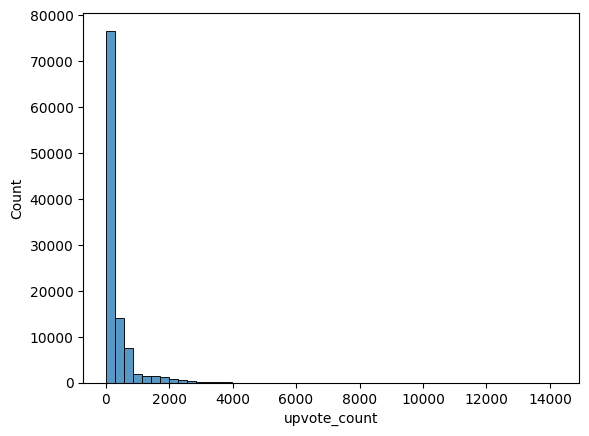

In [70]:
sns.histplot(df.upvote_count, bins=50)
plt.show()

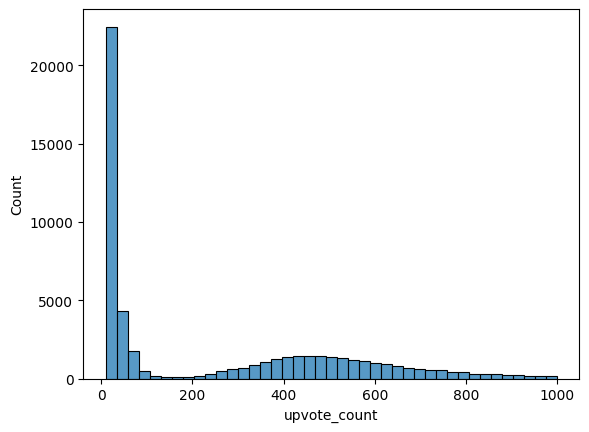

In [71]:
sns.histplot(df[(df.upvote_count >= 10) & (df.upvote_count < 1000)]['upvote_count'])
plt.show()

In [72]:
max = df.upvote_count.max()
max

np.int64(14212)

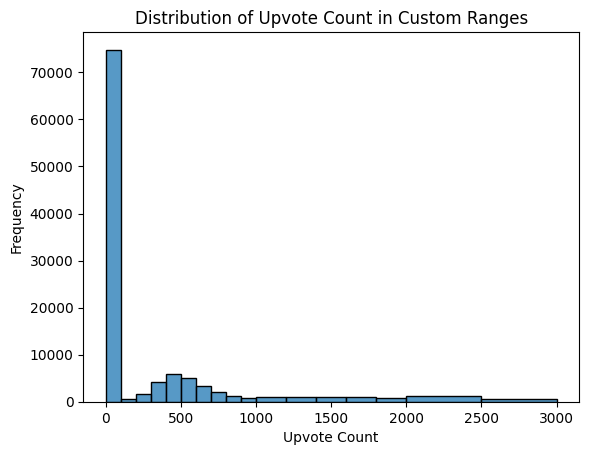

In [73]:
# Define the bin edges for your desired ranges
bin_edges = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000]

# Plot the histogram with custom bins
sns.histplot(df['upvote_count'], bins=bin_edges, kde=False)

# Add labels and title for clarity
plt.xlabel('Upvote Count')
plt.ylabel('Frequency')
plt.title('Distribution of Upvote Count in Custom Ranges')

# Show the plot
plt.show()

We should apply the log transformation to the upvote_count variable using the `np.log1p()` function to:
- reduce skewness
- improve model performance

<Axes: xlabel='upvote_count', ylabel='Count'>

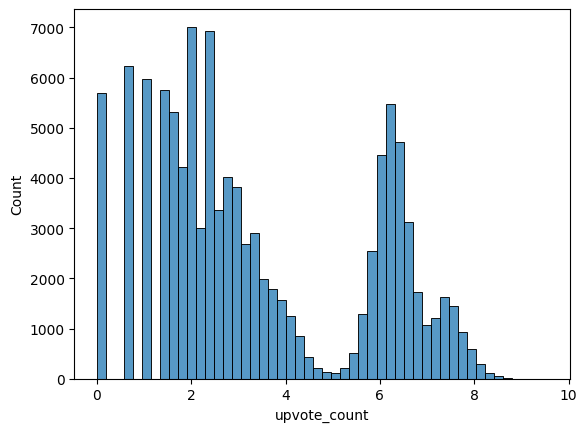

In [74]:
upvote_logs = np.log1p(df.upvote_count)
sns.histplot(upvote_logs, bins=50)

### Most popular tags

/var/folders/kn/5gkcnk6s4f1034nhqxdv53z80000gn/T/ipykernel_53414/593543458.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.values, y=top_tags.index, palette="viridis")


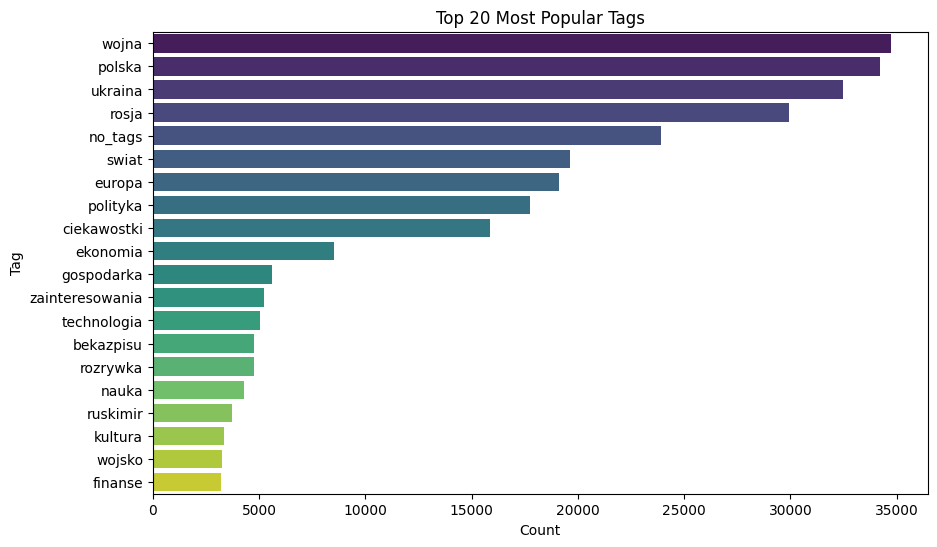

In [75]:
# Flatten the list of tags into a single series
all_tags = df['tags_list'].explode()
all_tags

# Count the occurrences of each tag
tag_counts = all_tags.value_counts()
tag_counts

top = 20
# Display the top 10 most popular tags
top_tags = tag_counts.head(top)

# Plot the top 10 tags
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.title(f"Top {top} Most Popular Tags")
plt.show()

### Average pluses based on time of day 

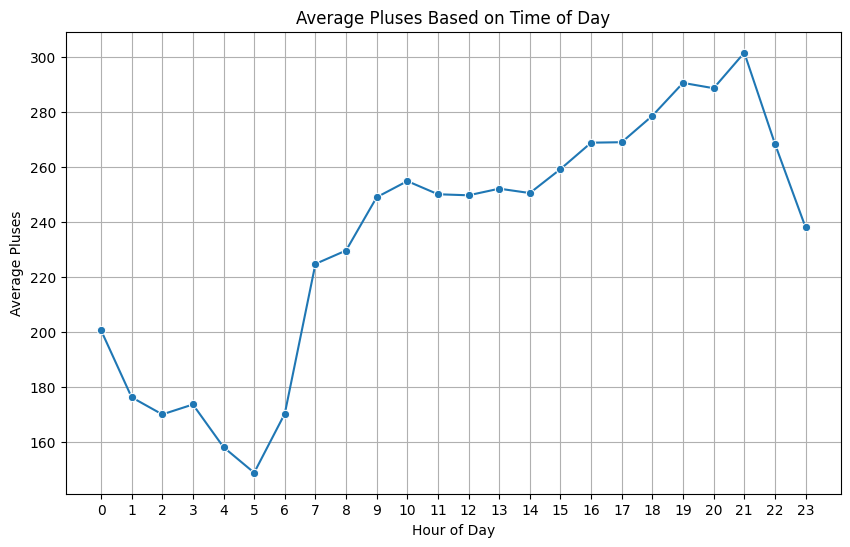

In [76]:
# Extract the hour of the day
df['hour_of_day'] = df['creation_date'].dt.hour
avg_upvotes_by_hour = df.groupby('hour_of_day')['upvote_count'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_upvotes_by_hour.index, y=avg_upvotes_by_hour.values, marker="o")
plt.title("Average Pluses Based on Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Pluses")
plt.xticks(range(0, 24))  # Show all 24 hours
plt.grid()
plt.show()

### Average Pluses Based on Day of the Week

/var/folders/kn/5gkcnk6s4f1034nhqxdv53z80000gn/T/ipykernel_53414/3557980320.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_upvotes_by_day.index, y=avg_upvotes_by_day.values, palette="viridis")


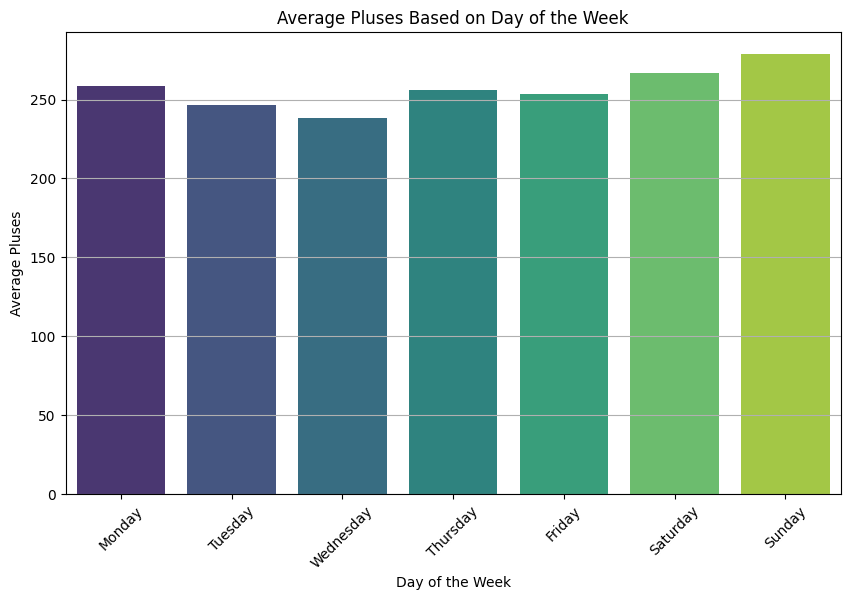

In [77]:
# Extract the day of the week
df['day_of_week'] = df['creation_date'].dt.day_name()
# Group by day of the week and calculate the average upvotes
avg_upvotes_by_day = df.groupby('day_of_week')['upvote_count'].mean()

# Sort days of the week in order (optional)
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
avg_upvotes_by_day = avg_upvotes_by_day.reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_upvotes_by_day.index, y=avg_upvotes_by_day.values, palette="viridis")
plt.title("Average Pluses Based on Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Pluses")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### 3 most popular tags during different times of the day (morning, day, evening, night)

Top tags during Morning:
  polska: 10923 occurrences
  wojna: 10012 occurrences
  ukraina: 9249 occurrences

Top tags during Afternoon:
  polska: 12975 occurrences
  wojna: 12895 occurrences
  ukraina: 12063 occurrences

Top tags during Evening:
  wojna: 10159 occurrences
  ukraina: 9613 occurrences
  polska: 8979 occurrences

Top tags during Night:
  wojna: 1665 occurrences
  ukraina: 1564 occurrences
  rosja: 1398 occurrences



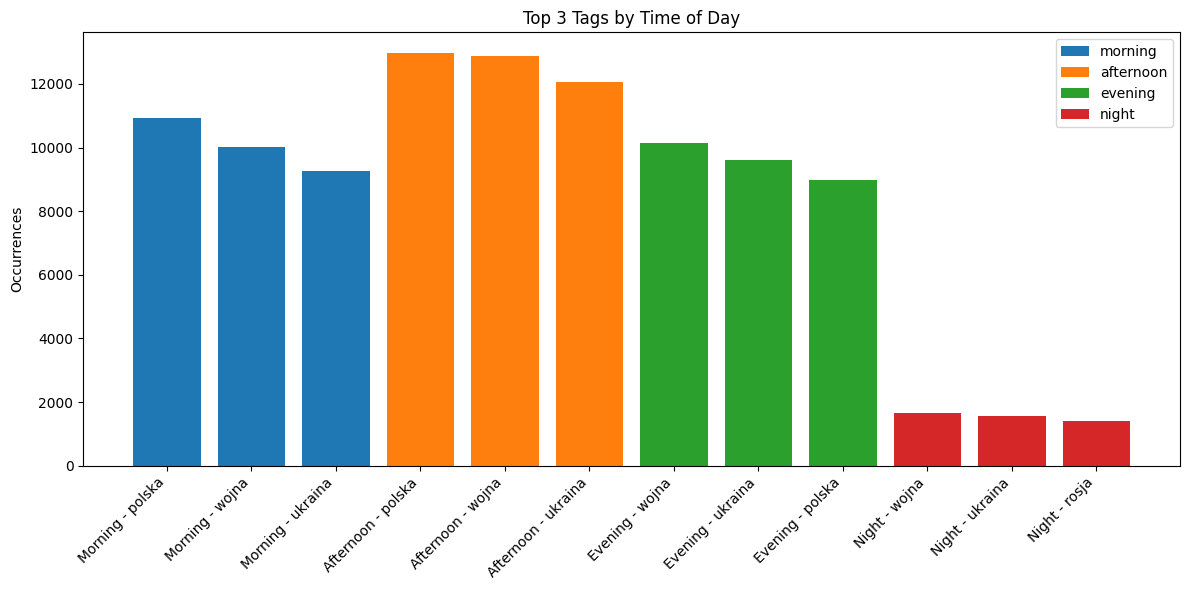

In [78]:
from collections import Counter

def classify_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'
    
    
df['time_of_day'] = df['creation_date'].dt.hour.apply(classify_time_of_day)

# Split tags and count occurrences for each time period
tag_counts = {
    period: Counter(
        tag
        for tags in df[df['time_of_day'] == period]['tags_sorted_joined']
        if tags  # Ensure tags are not NaN or empty
        for tag in tags.split('_')
    )
    for period in ['morning', 'afternoon', 'evening', 'night']
}

# Get the 3 most popular tags for each time period
top_tags = {period: counts.most_common(3) for period, counts in tag_counts.items()}

# Display Results
for period, tags in top_tags.items():
    print(f"Top tags during {period.capitalize()}:")
    for tag, count in tags:
        print(f"  {tag}: {count} occurrences")
    print()

# Visualize Results
plt.figure(figsize=(12, 6))
for idx, period in enumerate(['morning', 'afternoon', 'evening', 'night']):
    tags, counts = zip(*top_tags[period])
    plt.bar([f"{period.capitalize()} - {tag}" for tag in tags], counts, label=period)

plt.title("Top 3 Tags by Time of Day")
plt.ylabel("Occurrences")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Text analysis

#### Simple text analysis - title and description length features

In [79]:
df['title_char_length'] = df['title'].str.len()
df['description_char_length'] = df['description'].str.len()

df['title_word_count'] = df['title'].str.split().apply(len)
df['description_word_count'] = df['description'].str.split().apply(len)

df['title_unique_word_count'] = df['title'].str.split().apply(lambda x: len(set(x)))
df['description_unique_word_count'] = df['description'].str.split().apply(lambda x: len(set(x)))

#### Advanced text analysis - sentiment

Sentiment analysis evaluates the emotional tone of text.
- Polarity: Measures how positive or negative a text is. Values range from -1 (negative) to 1 (positive).
- Subjectivity: Measures how subjective (opinion-based) or objective (fact-based) the text is. Values range from 0 (completely objective) to 1 (completely subjective).

In [80]:
from textblob import TextBlob

In [81]:
# Sentiment analysis
df['title_sentiment_polarity'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['title_sentiment_subjectivity'] = df['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

df['description_sentiment_polarity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['description_sentiment_subjectivity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

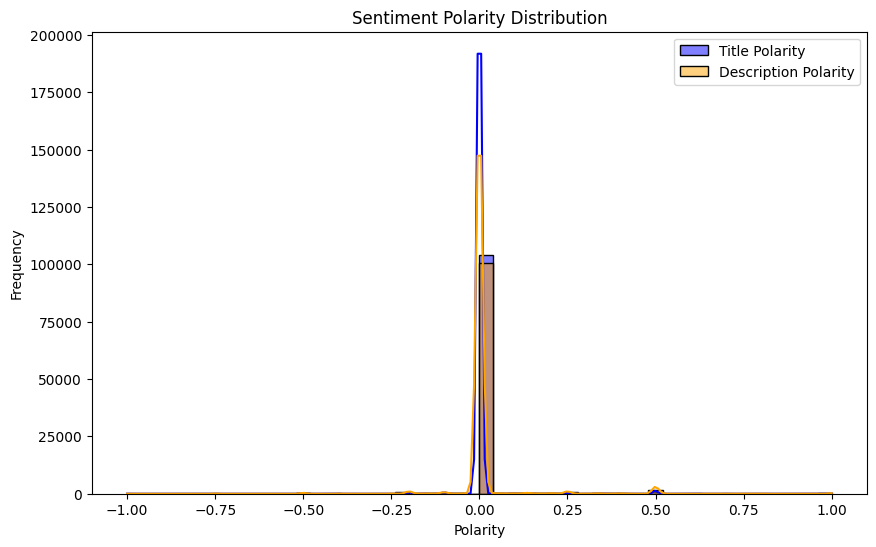

In [82]:
# Plot polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['title_sentiment_polarity'], bins=50, kde=True, color='blue', label='Title Polarity')
sns.histplot(df['description_sentiment_polarity'], bins=50, kde=True, color='orange', label='Description Polarity')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

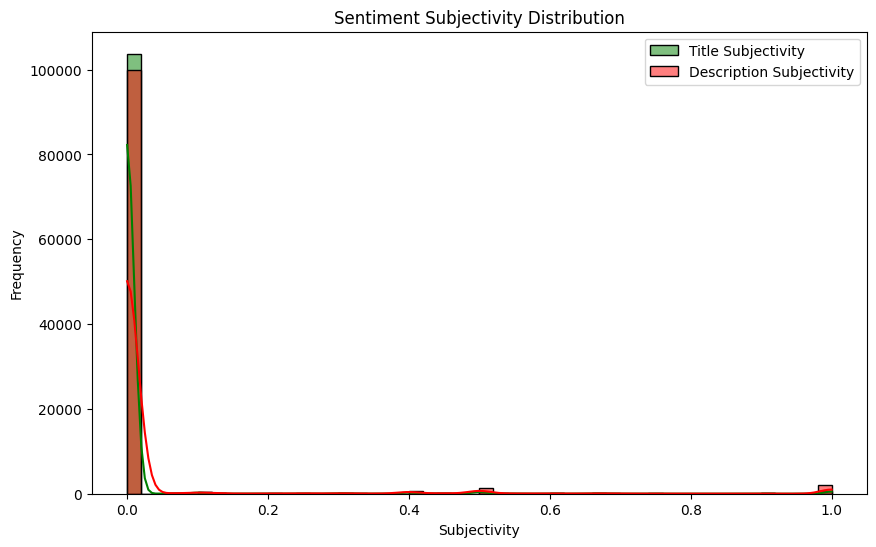

In [83]:
# Plot subjectivity distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['title_sentiment_subjectivity'], bins=50, kde=True, color='green', label='Title Subjectivity')
sns.histplot(df['description_sentiment_subjectivity'], bins=50, kde=True, color='red', label='Description Subjectivity')
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

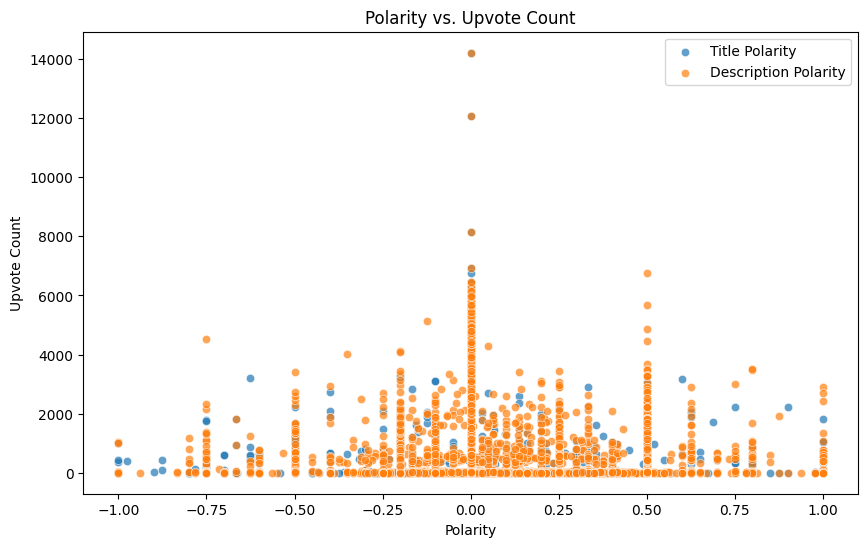

In [84]:
# Scatter plot of polarity vs. upvotes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='title_sentiment_polarity', y='upvote_count', label='Title Polarity', alpha=0.7)
sns.scatterplot(data=df, x='description_sentiment_polarity', y='upvote_count', label='Description Polarity', alpha=0.7)
plt.title('Polarity vs. Upvote Count')
plt.xlabel('Polarity')
plt.ylabel('Upvote Count')
plt.legend()
plt.show()

In [85]:
# Categorize polarity into sentiment groups
def categorize_sentiment(polarity):
    if polarity < -0.3:
        return 'Negative'
    elif polarity > 0.3:
        return 'Positive'
    else:
        return 'Neutral'   
    
    
df['title_sentiment_group'] = df['title_sentiment_polarity'].apply(categorize_sentiment)
df['description_sentiment_group'] = df['description_sentiment_polarity'].apply(categorize_sentiment)

# Group by sentiment and calculate average upvotes
title_sentiment_analysis = df.groupby('title_sentiment_group')['upvote_count'].mean()
description_sentiment_analysis = df.groupby('description_sentiment_group')['upvote_count'].mean()

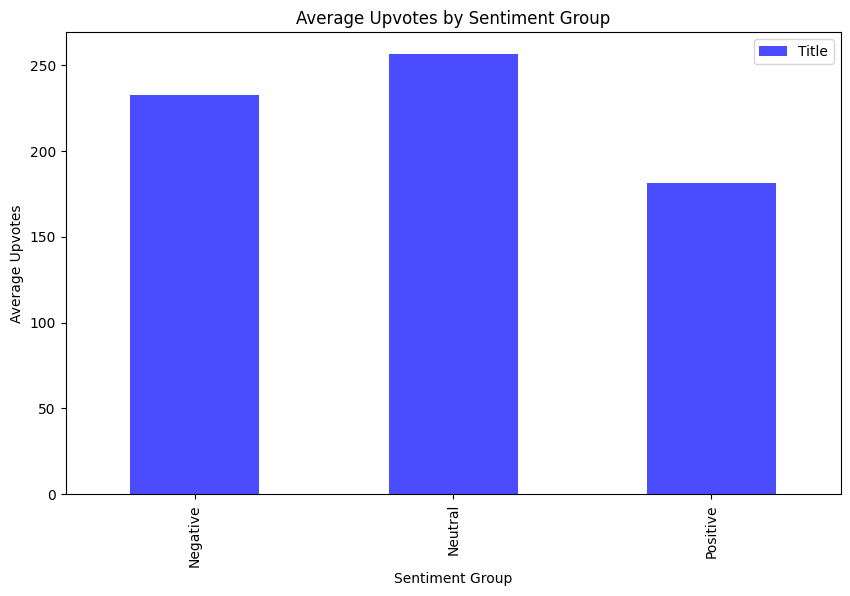

In [86]:
# Plot results for title
title_sentiment_analysis.plot(kind='bar', figsize=(10, 6), color='blue', alpha=0.7, label='Title')
plt.title('Average Upvotes by Sentiment Group')
plt.xlabel('Sentiment Group')
plt.ylabel('Average Upvotes')
plt.legend()
plt.show()

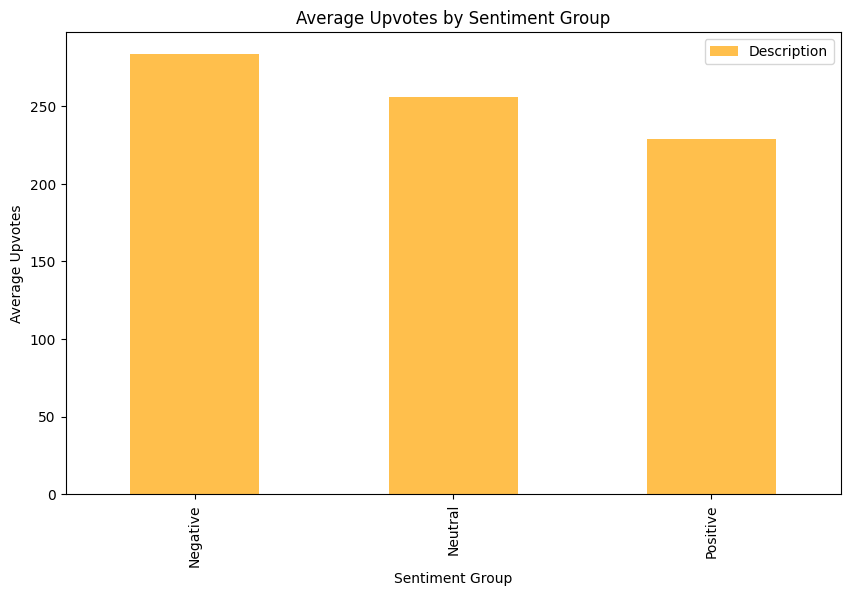

In [87]:
# Plot results for description
description_sentiment_analysis.plot(kind='bar', figsize=(10, 6), color='orange', alpha=0.7, label='Description')
plt.title('Average Upvotes by Sentiment Group')
plt.xlabel('Sentiment Group')
plt.ylabel('Average Upvotes')
plt.legend()
plt.show()

In [88]:
df['title_sentiment_group'].unique()


array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [89]:
df.title_sentiment_group.value_counts(normalize=True)

title_sentiment_group
Neutral     0.988367
Positive    0.008943
Negative    0.002690
Name: proportion, dtype: float64

In [90]:
df.description_sentiment_group.value_counts(normalize=True)

description_sentiment_group
Neutral     0.972215
Positive    0.023923
Negative    0.003862
Name: proportion, dtype: float64

In [91]:
df[df['title_sentiment_group'] == "Neutral"][["title"]].head()

,title
0,Ignatius - nasza gra ma dzisiaj premierę na ni...
1,"Panika Pokémon - masowa histeria, atak padaczk..."
4,Wyszedł remake THE HOUSE OF THE DEAD na Switcha.
5,Dziecięcy pozew zbiorowy przeciwko Nintendo
6,Delikatny mod...


In [92]:
df[df['title_sentiment_group'] == "Positive"][["title"]].head()

,title
20,Realny koszt wybudowania domu o pow. 140 m2 to...
325,"Dziś o 20.00 Super Ważna Decyzja FED, Bądź Na ..."
514,Getin Noble Bank informuje inwestorów o możliw...
567,"Top 10 Altcoinów: Alternatywne Kryptowaluty, Ś..."
663,"Super Ważne Informacje Dla PLN, Już Blisko Do ..."


In [93]:
df[df['title_sentiment_group'] == "Negative"][["title"]].head()

,title
2,Oko w oko z Game Boy Camera [ARN.EU]
3,Rekonstrukcja starego Game Boya
743,Game Developerzy nie są zainteresowani NFT i k...
975,UGLY - motocykl post apokaliptyczny
1033,W mieście Albuquerque stanie pomnik bohaterów ...


#### Keywords

In [94]:
import stopwordsiso as stopwords
import nltk
import string

In [95]:
stopwords.has_lang("pl")  # check if there is a stopwords for the language


True

In [96]:
# Download Polish stopwords
nltk.download('stopwords')
polish_stop_words = set(stopwords.stopwords('pl'))

print(polish_stop_words)  # Example: View Polish stopwords

{'ty', 'nam', 'przecież', 'może', 'naszego', 'od', 'znów', 'xi', 'im', 'acz', 'jego', 'toteż', 'wszystko', 'ze', 'jakiż', 'tobie', 'ich', 'wami', 'czasami', 'ach', 'inż', 'niego', 'przed', 'w', 'dość', 'vii', 'nich', 'sama', 'kimś', 'o', 'ciebie', 'ul', 'skąd', 'wiele', 'nad', 'wtedy', 'nasi', 'we', 'innych', 'go', 'bardzo', 'powinno', 'mną', 'sobą', 'przedtem', 'gdziekolwiek', 'żadne', 'dwa', 'wasze', 'je', 'temu', 'bo', 'mgr', 'sam', 'mi', 'tak', 'co', 'inne', 'oni', 'tam', 'gdy', 'jedno', 'viii', 'będą', 'kiedy', 'bardziej', 'was', 'on', 'godz', 'wszyscy', 'znowu', 'miał', 'dużo', 'teraz', 'są', 'xv', 'dokąd', 'jakkolwiek', 'nami', 'jak', 'gdzie', 'ktoś', 'oto', 'obok', 'inny', 'która', 'natychmiast', 'twoje', 'naszych', 'po', 'owszem', 'raz', 'tel', 'już', 'xiv', 'ku', 'pana', 'dziś', 'nią', 'tu', 'xii', 'ci', 'mogą', 'by', 'coraz', 'mam', 'wam', 'tobą', 'ono', 'pani', 'około', 'prof', 'tę', 'jeżeli', 'także', 'każdy', 'ta', 'bowiem', 'jakichś', 'u', 'można', 'oraz', 'jako', 'też',

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/piotrstanczak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
def tokenize_and_clean(text):
    # Convert to lowercase, remove punctuation, and split into words
    tokens = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
    # Remove Polish stopwords
    tokens = [word for word in tokens if word not in polish_stop_words]
    return tokens


# Tokenize titles and descriptions
df['title_tokens'] = df['title'].apply(lambda x: tokenize_and_clean(x) if isinstance(x, str) else [])
df['description_tokens'] = df['description'].apply(lambda x: tokenize_and_clean(x) if isinstance(x, str) else [])

In [98]:
df['title_tokens'].head()

0          [ignatius, gra, premierę, nintendo, switch]
1    [panika, pokémon, masowa, histeria, atak, pada...
2                 [oko, oko, game, boy, camera, arneu]
3                 [rekonstrukcja, starego, game, boya]
4    [wyszedł, remake, the, house, of, the, dead, s...
Name: title_tokens, dtype: object

In [99]:
# Flatten the lists of tokens
all_title_tokens = [token for tokens in df['title_tokens'] for token in tokens]
all_description_tokens = [token for tokens in df['description_tokens'] for token in tokens]

# # Count word frequencies
title_word_freq = Counter(all_title_tokens)
description_word_freq = Counter(all_description_tokens)

# # Get the top 20 most common words
top_title_keywords = title_word_freq.most_common(20)
top_description_keywords = description_word_freq.most_common(20)

print("Top 20 Title Keywords:", top_title_keywords)
print("Top 20 Description Keywords:", top_description_keywords)

Top 20 Title Keywords: [('rosji', 3732), ('ukrainie', 2896), ('ukrainy', 2893), ('rosja', 2488), ('polski', 2139), ('polsce', 1968), ('rosjanie', 1949), ('usa', 1675), ('polska', 1583), ('ukraina', 1479), ('–', 1451), ('putina', 1438), ('putin', 1418), ('wojny', 1265), ('ukrainę', 1210), ('pis', 1193), ('rosyjski', 1155), ('wojna', 1132), ('2022', 1096), ('rosyjskie', 1062)]
Top 20 Description Keywords: [('–', 7723), ('rosji', 6955), ('ukrainy', 6757), ('ukrainie', 5269), ('polski', 3772), ('ukrainę', 3420), ('polsce', 3404), ('wojny', 2776), ('osób', 2676), ('powiedział', 2656), ('proc', 2641), ('the', 2527), ('rosyjskich', 2481), ('kraju', 2466), ('rosja', 2427), ('rosyjskiej', 2378), ('usa', 2284), ('r', 2247), ('polska', 2244), ('rosyjskie', 2236)]


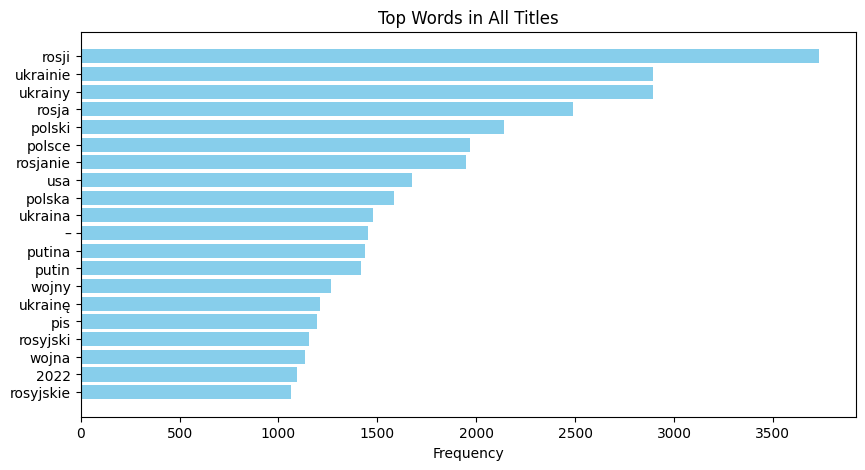

In [100]:
title_words, title_counts = zip(*top_title_keywords)

plt.figure(figsize=(10, 5))
plt.barh(title_words, title_counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top Words in All Titles')
plt.gca().invert_yaxis()  
plt.show()

#### Words used in highly upvoted posts

In [101]:
popular_threshold = 100
popular_posts = df[df['upvote_count'] > popular_threshold]
popular_posts.head().T

,13,14,15,16,17
link_id,6729919,6718569,6716143,6620765,6612167
title,Polska pójdzie drogą Czech? Co czwarty wiejski...,Projekty domów do 70 m2 za darmo do pobrania w...,"Kolor dachu niezgodny z MPZP, budowa zatrzymana.","Z cenami materiałów budowlanych było źle, tera...",Galopująca drożyzna w sklepach budowlanych. &q...
description,Już teraz odsetek niezamieszkanych domów na po...,Projekty domów do 70 m2 można już pobrać ze st...,Budowa domu zatrzymana przez nadzór budowlany....,Materiały budowlane biją kolejne rekordy droży...,Raport Grupy PSB: ceny płyt OSB wzrosły w marc...
source_url,https://gospodarka.dziennik.pl/news/artykuly/8...,https://muratordom.pl/przed-budowa/wybor-proje...,http://www.youtube.com/watch?v=xWrl_cR9x18,https://regiodom.pl/z-materialami-budowlanymi-...,https://www.wykop.pl/link/partnerredirect/6612...
upvote_count,1290,826,498,656,506
downvote_count,95,18,23,18,11
comments_count,371,354,314,288,236
related_count,2,3,3,1,2
creation_date,2022-07-07 12:25:37,2022-06-28 10:57:45,2022-06-26 13:05:47,2022-04-18 12:54:58,2022-04-12 10:22:03
author_user_id,93702,27525,48931,93702,39248


In [102]:
most_common_words = 10

In [103]:
popular_title_tokens = [token for tokens in popular_posts['title_tokens'] for token in tokens]
popular_description_tokens = [token for tokens in popular_posts['description_tokens'] for token in tokens]

popular_title_word_freq = Counter(popular_title_tokens)
popular_description_word_freq = Counter(popular_description_tokens)

popular_title_top_words = popular_title_word_freq.most_common(most_common_words)
popular_description_top_words = popular_description_word_freq.most_common(most_common_words)

print(f"Top {most_common_words} words in popular titles:", popular_title_top_words)
print(f"Top {most_common_words} words in popular descriptions:", popular_description_top_words)

Top 10 words in popular titles: [('rosji', 1638), ('ukrainie', 1107), ('ukrainy', 1088), ('rosja', 1022), ('rosjanie', 905), ('polski', 617), ('polsce', 584), ('rosyjski', 573), ('ukraina', 564), ('usa', 563)]
Top 10 words in popular descriptions: [('rosji', 2935), ('ukrainy', 2734), ('–', 2262), ('ukrainie', 2022), ('ukrainę', 1431), ('rosyjskich', 1194), ('powiedział', 1028), ('polski', 1016), ('rosyjskiej', 1012), ('rosyjskie', 985)]


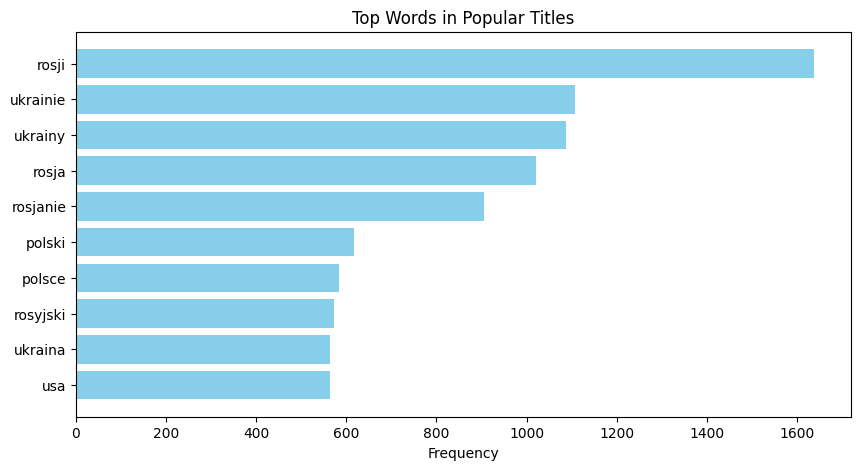

In [104]:
title_words, title_counts = zip(*popular_title_top_words)

plt.figure(figsize=(10, 5))
plt.barh(title_words, title_counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top Words in Popular Titles')
plt.gca().invert_yaxis()
plt.show()

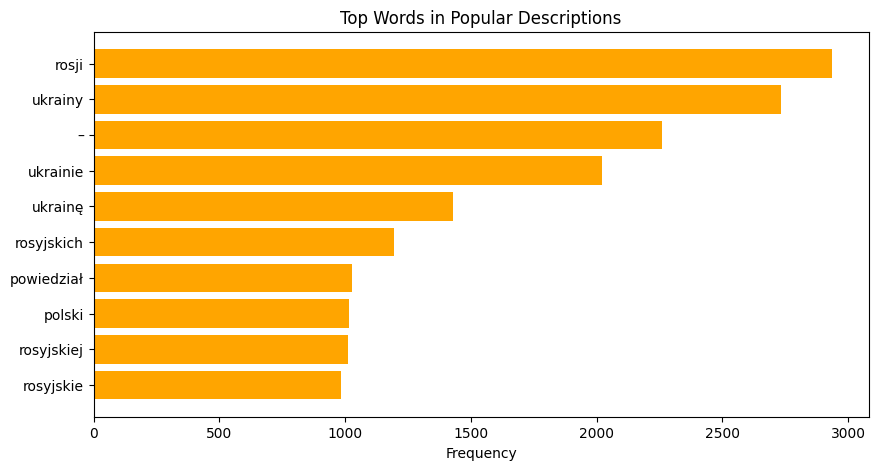

In [105]:
desc_words, desc_counts = zip(*popular_description_top_words)

plt.figure(figsize=(10, 5))
plt.barh(desc_words, desc_counts, color='orange')
plt.xlabel('Frequency')
plt.title('Top Words in Popular Descriptions')
plt.gca().invert_yaxis()
plt.show()

In [106]:
words_to_check = [word for word, count in popular_title_top_words]
words_to_check

for word in words_to_check:
    df[f'title_contains_{word}'] = df['title'].str.contains(word, case=False, na=False).astype(int)

In [107]:
# Compare average upvote_count
impact_analysis = {
    word: df.groupby(f'title_contains_{word}')['upvote_count'].mean()
    for word in words_to_check
}

# Display results
for word, impact in impact_analysis.items():
    print(f"Word: {word}, Without: {impact[0]:.2f}, With: {impact[1]:.2f}")

Word: rosji, Without: 249.72, With: 417.19
Word: ukrainie, Without: 254.07, With: 312.27
Word: ukrainy, Without: 253.55, With: 331.87
Word: rosja, Without: 248.15, With: 382.90
Word: rosjanie, Without: 252.86, With: 403.92
Word: polski, Without: 255.28, With: 265.92
Word: polsce, Without: 255.35, With: 274.24
Word: rosyjski, Without: 248.63, With: 400.81
Word: ukraina, Without: 254.69, With: 323.21
Word: usa, Without: 255.17, With: 282.14


#### Text Complexity Features

In [108]:
df['title_avg_word_length'] = df['title'].apply(lambda x: np.mean([len(word) for word in x.split()]) if pd.notnull(x) else 0)
df['description_avg_word_length'] = df['description'].apply(lambda x: np.mean([len(word) for word in x.split()]) if pd.notnull(x) else 0)

/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#### NLP-Based Features

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [110]:
# Initialize TF-IDF
tfidf = TfidfVectorizer(max_features=30)  # Adjust max_features as needed
tfidf_matrix = tfidf.fit_transform(df['title'].fillna(''))

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.head().T


,0,1,2,3,4
będzie,0.000000,0.0,0.0,0.0,0.0
co,0.000000,0.0,0.0,0.0,0.0
czy,0.000000,1.0,0.0,0.0,0.0
dla,0.000000,0.0,0.0,0.0,0.0
do,0.000000,0.0,0.0,0.0,0.0
jak,0.000000,0.0,0.0,0.0,0.0
jest,0.000000,0.0,0.0,0.0,0.0
już,0.000000,0.0,0.0,0.0,0.0
ma,0.884133,0.0,0.0,0.0,0.0
na,0.467236,0.0,0.0,0.0,1.0


In [111]:
tfidf_top = 10

In [112]:
correlations = tfidf_df.corrwith(df['upvote_count'])

# Sort by absolute correlation
correlations = correlations.abs().sort_values(ascending=False)

print("Top correlated words with upvote_count:")
print(correlations.head(tfidf_top))

Top correlated words with upvote_count:
rosji       0.058193
rosjanie    0.037645
nie         0.036166
czy         0.034691
że          0.027532
za          0.027452
rosja       0.025814
co          0.024276
ukrainy     0.022895
quot        0.022119
dtype: float64


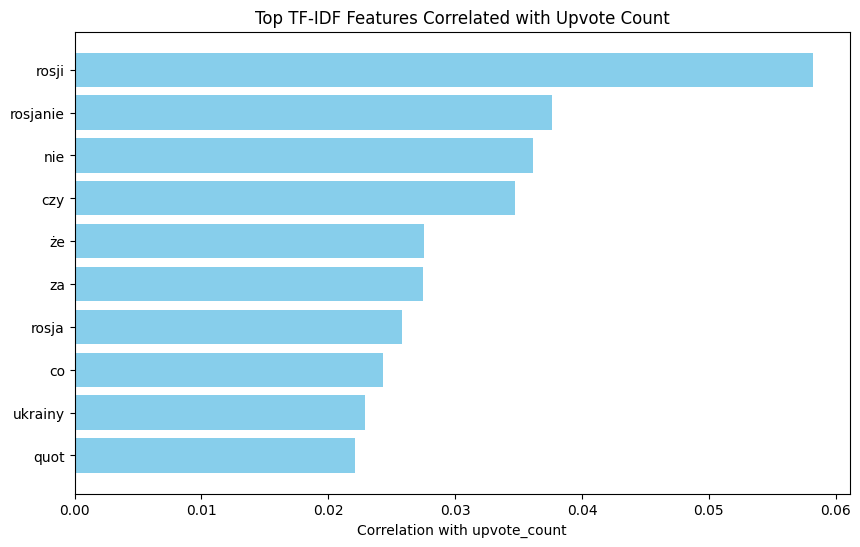

In [113]:
top_words = correlations.head(tfidf_top).index
top_corr = correlations.head(tfidf_top).values

plt.figure(figsize=(10, 6))
plt.barh(top_words, top_corr, color='skyblue')
plt.xlabel('Correlation with upvote_count')
plt.title('Top TF-IDF Features Correlated with Upvote Count')
plt.gca().invert_yaxis()
plt.show()

In [114]:
tfidf_top_features = correlations.head(tfidf_top).index
tfidf_top_features

Index(['rosji', 'rosjanie', 'nie', 'czy', 'że', 'za', 'rosja', 'co', 'ukrainy',
       'quot'],
      dtype='object')

In [115]:
# Filter tfidf_df to include only the top features
tfidf_top_df = tfidf_df[tfidf_top_features]
tfidf_top_df

# Concatenate the filtered TF-IDF DataFrame with the original DataFrame
df = pd.concat([df.reset_index(drop=True), tfidf_top_df.reset_index(drop=True)], axis=1)

In [116]:
df.columns


Index(['link_id', 'title', 'description', 'source_url', 'upvote_count',
       'downvote_count', 'comments_count', 'related_count', 'creation_date',
       'author_user_id', 'plus18', 'status', 'can_vote', 'is_hot', 'archived',
       'tags', 'tags_cleaned', 'tags_list', 'tags_sorted_joined',
       'hour_of_day', 'day_of_week', 'time_of_day', 'title_char_length',
       'description_char_length', 'title_word_count', 'description_word_count',
       'title_unique_word_count', 'description_unique_word_count',
       'title_sentiment_polarity', 'title_sentiment_subjectivity',
       'description_sentiment_polarity', 'description_sentiment_subjectivity',
       'title_sentiment_group', 'description_sentiment_group', 'title_tokens',
       'description_tokens', 'title_contains_rosji', 'title_contains_ukrainie',
       'title_contains_ukrainy', 'title_contains_rosja',
       'title_contains_rosjanie', 'title_contains_polski',
       'title_contains_polsce', 'title_contains_rosyjski',
      

In [117]:
df.head().T

,0,1,2,3,4
link_id,6697485,6667641,6666053,6614917,6608459
title,Ignatius - nasza gra ma dzisiaj premierę na ni...,"Panika Pokémon - masowa histeria, atak padaczk...",Oko w oko z Game Boy Camera [ARN.EU],Rekonstrukcja starego Game Boya,Wyszedł remake THE HOUSE OF THE DEAD na Switcha.
description,Ignatius to nastrojowa gra logiczno-platformow...,"Panika Pokémon, czyli dlaczego setki dzieci w ...",Aparat fotograficzny jako akcesorium do Game B...,Zakupiony na eBayu i przywrócony do stanu fabr...,"Rail shooter, klasyk z automatu. To co można b..."
source_url,https://www.nintendo.com/store/products/ignati...,https://absurdusy.blogspot.com/2022/05/panika-...,http://www.youtube.com/watch?v=ZKE3DrtTWF0,http://www.youtube.com/watch?v=iUrolFnAUcc,https://www.nintendo.co.uk/Games/Nintendo-Swit...
upvote_count,37,14,15,6,8
downvote_count,1,0,5,3,4
comments_count,5,4,1,0,14
related_count,1,0,1,0,4
creation_date,2022-06-10 18:44:31,2022-05-20 22:15:01,2022-05-19 21:16:05,2022-04-14 01:23:41,2022-04-09 18:30:50
author_user_id,86627,58441,22595,6491,65137


In [118]:
tfidf = TfidfVectorizer(max_features=30)
tfidf_matrix = tfidf.fit_transform(df['tags_sorted_joined'])

# Convert to DataFrame
tfidf_tags_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_tags_df.head().T

,0,1,2,3,4
astronomia_kosmos_liganauki_nauka_zainteresowania,0.0,0.0,0.0,0.0,0.0
bekazpisu_polityka_polska,0.0,0.0,0.0,0.0,0.0
ekonomia_kultura_nauka_polityka_polska_zainteresowania,0.0,0.0,0.0,0.0,0.0
ekonomia_polityka_polska,0.0,0.0,0.0,0.0,0.0
europa_kultura_nauka_polityka_swiat_zainteresowania,0.0,0.0,0.0,0.0,0.0
europa_polityka_polska_rosja_ukraina_wojna,0.0,0.0,0.0,0.0,0.0
europa_polityka_rosja_swiat_ukraina_wojna,0.0,0.0,0.0,0.0,0.0
europa_polska_rosja_swiat_ukraina_wojna,0.0,0.0,0.0,0.0,0.0
europa_polska_rosja_ukraina_wojna,0.0,0.0,0.0,0.0,0.0
europa_putin_rosja_ruskimir_ukraina_wojna,0.0,0.0,0.0,0.0,0.0


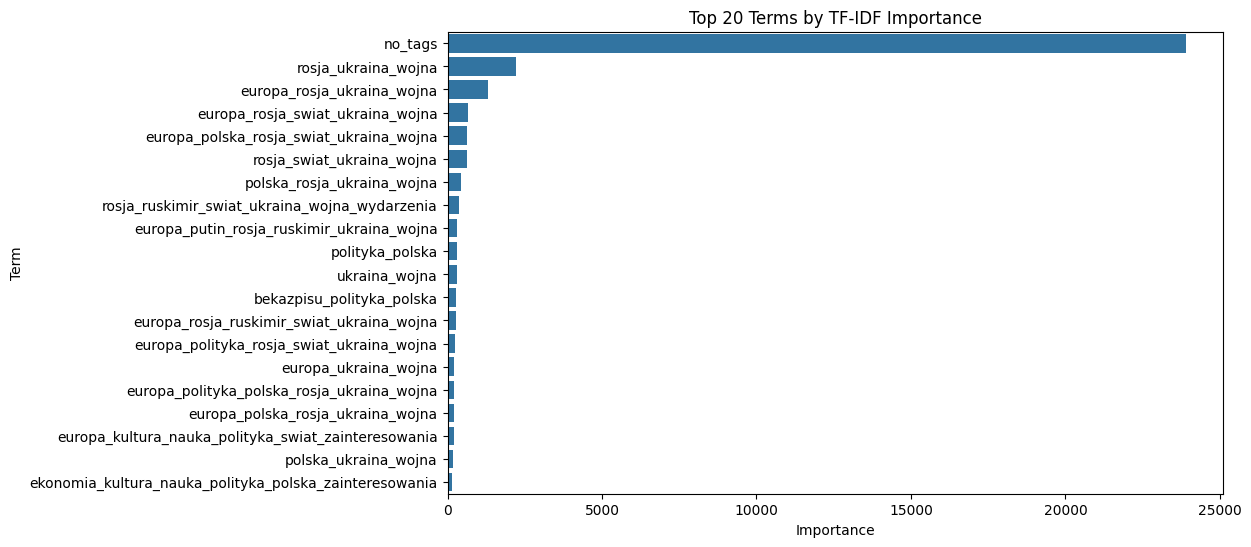

In [119]:
# Calculate the sum of TF-IDF values for each term across all posts
term_sums = tfidf_matrix.sum(axis=0).A1
term_names = tfidf.get_feature_names_out()

# Create a DataFrame with term importance
term_df = pd.DataFrame(list(zip(term_names, term_sums)), columns=['Term', 'Importance'])
term_df = term_df.sort_values(by='Importance', ascending=False)

# Plot top terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Term', data=term_df.head(20))
plt.title('Top 20 Terms by TF-IDF Importance')
plt.show()

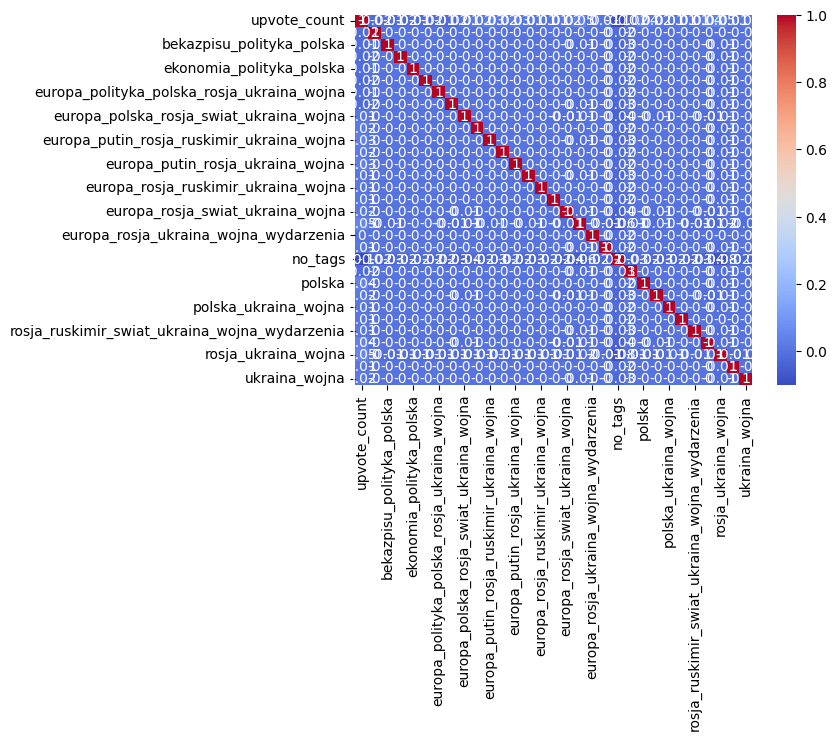

In [120]:
# Calculate correlation between the TF-IDF features and upvote_count
correlation_matrix = df[['upvote_count']].join(tfidf_tags_df)
correlations = correlation_matrix.corr()
sns.heatmap(correlations.round(2), annot=True, cmap='coolwarm')
plt.show()

In [121]:
all_tags = df['tags_list'].explode()
all_tags

# Count the occurrences of each tag
tag_counts = all_tags.value_counts()
tag_counts

# Display the top 10 most popular tags
top_tags = tag_counts.head(top).index
top_tags

top_tags_features = []

# Loop through each of the top X tags and create a new binary feature for each tag
for tag in top_tags:
    # print(tag)
    tag_feature_name = f'tags_contains_{tag}'
    df[tag_feature_name] = df['tags_sorted_joined'].str.contains(tag, case=False, na=False).astype(int)
    top_tags_features.append(tag_feature_name)

#### Feature importance

In [122]:
global_is_hot_rate = df.is_hot.mean()
round(global_is_hot_rate, 2)

np.float64(0.06)

In [123]:
df.plus18.value_counts(normalize=True)

plus18
False    0.999981
True     0.000019
Name: proportion, dtype: float64

In [124]:
df[df.plus18 == True].source_url

57457     https://twitter.com/AnonOpsSE/status/155120621...
103423                        https://streamable.com/se3q6g
Name: source_url, dtype: object

In [125]:
plus18_true = df[df.plus18 == True].is_hot.mean()
plus18_false = df[df.plus18 == False].is_hot.mean()
plus18_true, plus18_false, global_is_hot_rate

(np.float64(0.0),
 np.float64(0.060455785437739634),
 np.float64(0.060454651980314036))

As you can see, the 18plus content does not contribute into a number of pluses

In [126]:
columns = list(df.columns)
columns.remove("tags_list")
columns.remove("title_tokens")
columns.remove("description_tokens")
df[columns].nunique()

link_id                   106675
title                     106267
description               105355
source_url                106572
upvote_count                3256
                           ...  
tags_contains_nauka            2
tags_contains_ruskimir         2
tags_contains_kultura          2
tags_contains_wojsko           2
tags_contains_finanse          2
Length: 75, dtype: int64

In [127]:
df["time_of_day"].unique()

array(['evening', 'night', 'morning', 'afternoon'], dtype=object)

In [128]:
df["tags_sorted_joined"].unique()

array(['gry_konsole_nintendo_nintendoswitch_rozrywka_switch',
       'anime_ciekawostki_nintendo_pokemon_pokemongo_swiat',
       'arhneu_ciekawostki_gameboy_konsole_nintendo_retrogaming', ...,
       'bialorus_europa_historia_polska_wydarzenia',
       'archeologia_egipcjanie_egipt_egiptologia_historia_starozytnosc',
       'no_tags'], shape=(51947,), dtype=object)

In [129]:
tfidf_top_features

Index(['rosji', 'rosjanie', 'nie', 'czy', 'że', 'za', 'rosja', 'co', 'ukrainy',
       'quot'],
      dtype='object')

In [130]:
features = [        
    'downvote_count',
    'comments_count',
    'related_count',    
    'plus18',    
    'is_hot',    
    'tags_sorted_joined',
    'hour_of_day',
    'day_of_week',
    'time_of_day',
    'title_char_length',
    'description_char_length',
    'title_word_count',
    'description_word_count',
    'title_unique_word_count',
    'description_unique_word_count',        
    'title_sentiment_polarity',
    'title_sentiment_subjectivity', 
    'description_sentiment_polarity',
    'description_sentiment_subjectivity', 
    'title_sentiment_group',
    'description_sentiment_group',   
]

numerical = [
    'comments_count',
    'related_count',
    'hour_of_day',
    'title_char_length',
    'description_char_length',
    'title_word_count',
    'description_word_count',
    'title_unique_word_count',
    'description_unique_word_count',
    'title_avg_word_length',
    'description_avg_word_length',
]

categorical = [
    'plus18',
    'tags_sorted_joined',
    'day_of_week',
    'time_of_day',
]

In [131]:
for c in categorical:
    print(c)
    df_group = df.groupby(c).is_hot.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_is_hot_rate
    df_group['risk'] = df_group['mean'] / global_is_hot_rate
    display(df_group)
    print()
    print()

plus18


,mean,count,diff,risk
plus18,,,,
False,0.060456,106673,0.000001,1.000019
True,0.000000,2,-0.060455,0.000000




tags_sorted_joined


,mean,count,diff,risk
tags_sorted_joined,,,,
#podsluch_afera_europa_inwigilacja_pegasus_wegry,0.000000,1,-0.060455,0.000000
007_bladerunner_film_filmnawieczor_jamesbond_kino,0.000000,1,-0.060455,0.000000
00magnetar00_aliexpress_promocja_promocje_rozrywka_technologia,0.000000,1,-0.060455,0.000000
00s_90s_ciekawostki_polska_rolnictwo_wies,0.000000,1,-0.060455,0.000000
00s_daftpunk_nostalgia_reklama_rozrywka,0.000000,1,-0.060455,0.000000
...,...,...,...,...
wyborcza,0.000000,1,-0.060455,0.000000
wykop,0.666667,3,0.606212,11.027549
wypadek,0.000000,3,-0.060455,0.000000




day_of_week


,mean,count,diff,risk
day_of_week,,,,
Friday,0.060465,15943,0.000011,1.000178
Monday,0.063487,16460,0.003033,1.050163
Saturday,0.057898,12332,-0.002557,0.957712
Sunday,0.066155,12516,0.005701,1.094297
Thursday,0.061832,16270,0.001377,1.022776
Tuesday,0.058376,16565,-0.002079,0.965618
Wednesday,0.055760,16589,-0.004695,0.922342




time_of_day


,mean,count,diff,risk
time_of_day,,,,
afternoon,0.063945,39878,0.003490,1.057736
evening,0.070792,30512,0.010337,1.170990
morning,0.053736,31357,-0.006719,0.888865
night,0.010958,4928,-0.049497,0.181256


In [132]:
from sklearn.metrics import mutual_info_score

In [259]:
def mutual_info(series):
    return mutual_info_score(series, df.upvote_count)

In [260]:
mi = df[categorical].apply(mutual_info)
mi.sort_values(ascending=False)

na                             0.520239
nie                            0.348368
quot                           0.343162
do                             0.282861
się                            0.279344
                                 ...   
tags_contains_jedzenie         0.002934
tags_contains_astronomia       0.002571
tags_contains_gotujzwykopem    0.002504
title_contains_covid19         0.001009
plus18                         0.000147
Length: 303, dtype: float64

In [135]:
numerical

['comments_count',
 'related_count',
 'hour_of_day',
 'title_char_length',
 'description_char_length',
 'title_word_count',
 'description_word_count',
 'title_unique_word_count',
 'description_unique_word_count',
 'title_avg_word_length',
 'description_avg_word_length']

In [136]:
copied_numerical = numerical + ["upvote_count"].copy()
correlations = []
for c in numerical:
    copied_numerical.remove(c)
    correlation = df[copied_numerical].corrwith(df[c])
    correlation.index = [f"{c} and {col}" for col in correlation.index]
    correlations.append(correlation)

correlations_sorted = pd.concat(correlations).sort_values(ascending=False)
correlations_sorted

title_word_count and title_unique_word_count                     0.994290
description_word_count and description_unique_word_count         0.992611
description_char_length and description_unique_word_count        0.970763
description_char_length and description_word_count               0.968485
title_char_length and title_unique_word_count                    0.853392
                                                                   ...   
hour_of_day and title_char_length                               -0.038644
description_unique_word_count and description_avg_word_length   -0.073003
description_word_count and description_avg_word_length          -0.083673
title_unique_word_count and title_avg_word_length               -0.349614
title_word_count and title_avg_word_length                      -0.361791
Length: 66, dtype: float64

In [137]:
df[numerical].corrwith(df.upvote_count).sort_values(ascending=False)

comments_count                   0.681367
related_count                    0.491230
title_char_length                0.070710
title_unique_word_count          0.054887
title_word_count                 0.054094
hour_of_day                      0.042938
title_avg_word_length            0.018974
description_unique_word_count    0.005861
description_char_length          0.005581
description_word_count           0.005311
description_avg_word_length     -0.008254
dtype: float64

In [138]:
correlation = df[["upvote_count"] + numerical].corr()
correlation

,upvote_count,comments_count,related_count,hour_of_day,title_char_length,description_char_length,title_word_count,description_word_count,title_unique_word_count,description_unique_word_count,title_avg_word_length,description_avg_word_length
upvote_count,1.000000,0.681367,0.491230,0.042938,0.070710,0.005581,0.054094,0.005311,0.054887,0.005861,0.018974,-0.008254
comments_count,0.681367,1.000000,0.558365,0.020875,0.064877,0.020787,0.064769,0.028700,0.065303,0.028475,-0.005415,-0.018591
related_count,0.491230,0.558365,1.000000,0.031259,-0.009109,-0.025384,-0.009872,-0.023228,-0.010063,-0.023627,0.003159,-0.008250
hour_of_day,0.042938,0.020875,0.031259,1.000000,-0.038644,-0.026730,-0.037140,-0.029496,-0.037964,-0.029894,0.004473,0.007668
title_char_length,0.070710,0.064877,-0.009109,-0.038644,1.000000,0.334630,0.849349,0.313972,0.853392,0.321479,0.130894,0.026166
description_char_length,0.005581,0.020787,-0.025384,-0.026730,0.334630,1.000000,0.275710,0.968485,0.279797,0.970763,0.054924,0.038980
title_word_count,0.054094,0.064769,-0.009872,-0.037140,0.849349,0.275710,1.000000,0.288926,0.994290,0.290524,-0.361791,-0.029221
description_word_count,0.005311,0.028700,-0.023228,-0.029496,0.313972,0.968485,0.288926,1.000000,0.291817,0.992611,0.000768,-0.083673
title_unique_word_count,0.054887,0.065303,-0.010063,-0.037964,0.853392,0.279797,0.994290,0.291817,1.000000,0.294298,-0.349614,-0.027695
description_unique_word_count,0.005861,0.028475,-0.023627,-0.029894,0.321479,0.970763,0.290524,0.992611,0.294298,1.000000,0.009496,-0.073003


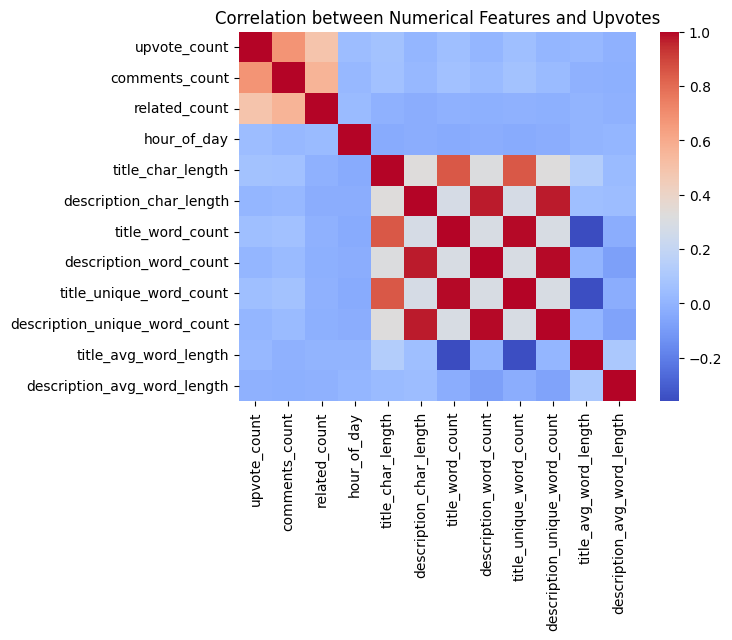

In [139]:
sns.heatmap(correlation.round(2), annot=False, cmap='coolwarm')
plt.title('Correlation between Numerical Features and Upvotes')
plt.show()

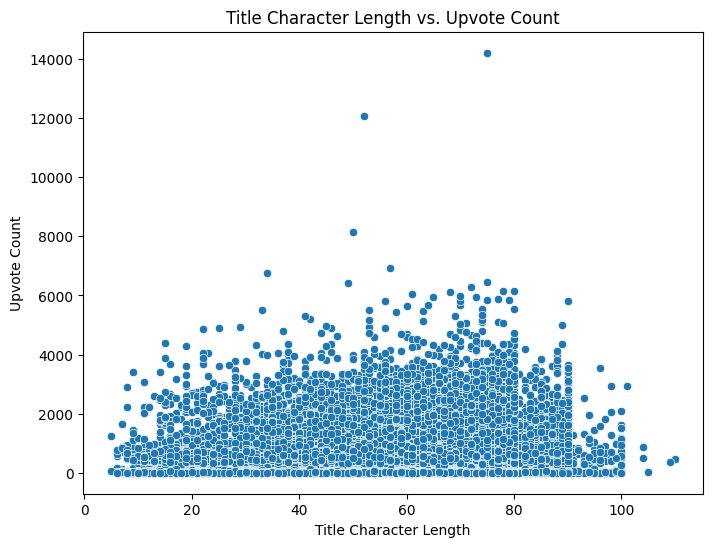

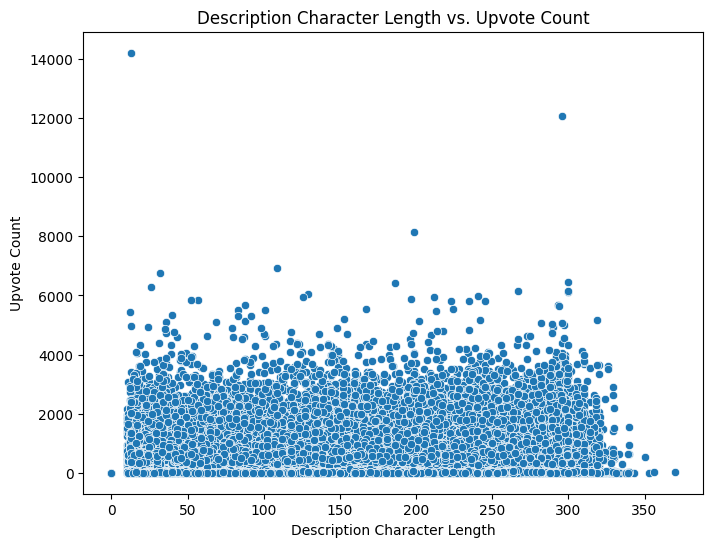

In [140]:
# Scatter plot for title length vs. upvote count
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='title_char_length', y='upvote_count')
plt.title('Title Character Length vs. Upvote Count')
plt.xlabel('Title Character Length')
plt.ylabel('Upvote Count')
plt.show()

# Scatter plot for description length vs. upvote count
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='description_char_length', y='upvote_count')
plt.title('Description Character Length vs. Upvote Count')
plt.xlabel('Description Character Length')
plt.ylabel('Upvote Count')
plt.show()

/var/folders/kn/5gkcnk6s4f1034nhqxdv53z80000gn/T/ipykernel_53414/430374183.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_upvotes_by_title_length = df.groupby('title_length_bins')['upvote_count'].mean()


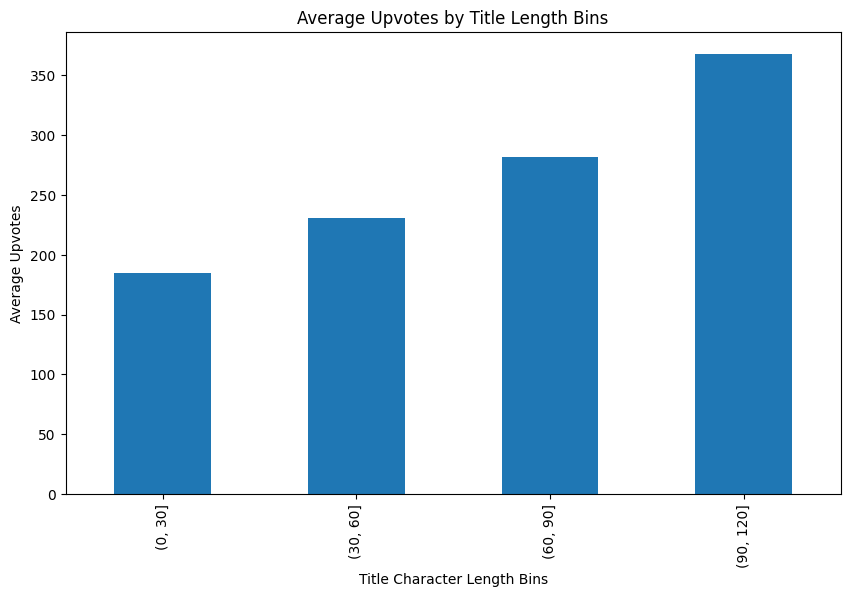

In [141]:
# Group by bins of title length
df['title_length_bins'] = pd.cut(df['title_char_length'], bins=range(0, 150, 30))

# Calculate average upvotes for each bin
avg_upvotes_by_title_length = df.groupby('title_length_bins')['upvote_count'].mean()

# Plot average upvotes
avg_upvotes_by_title_length.plot(kind='bar', figsize=(10, 6))
plt.title('Average Upvotes by Title Length Bins')
plt.xlabel('Title Character Length Bins')
plt.ylabel('Average Upvotes')
plt.show()

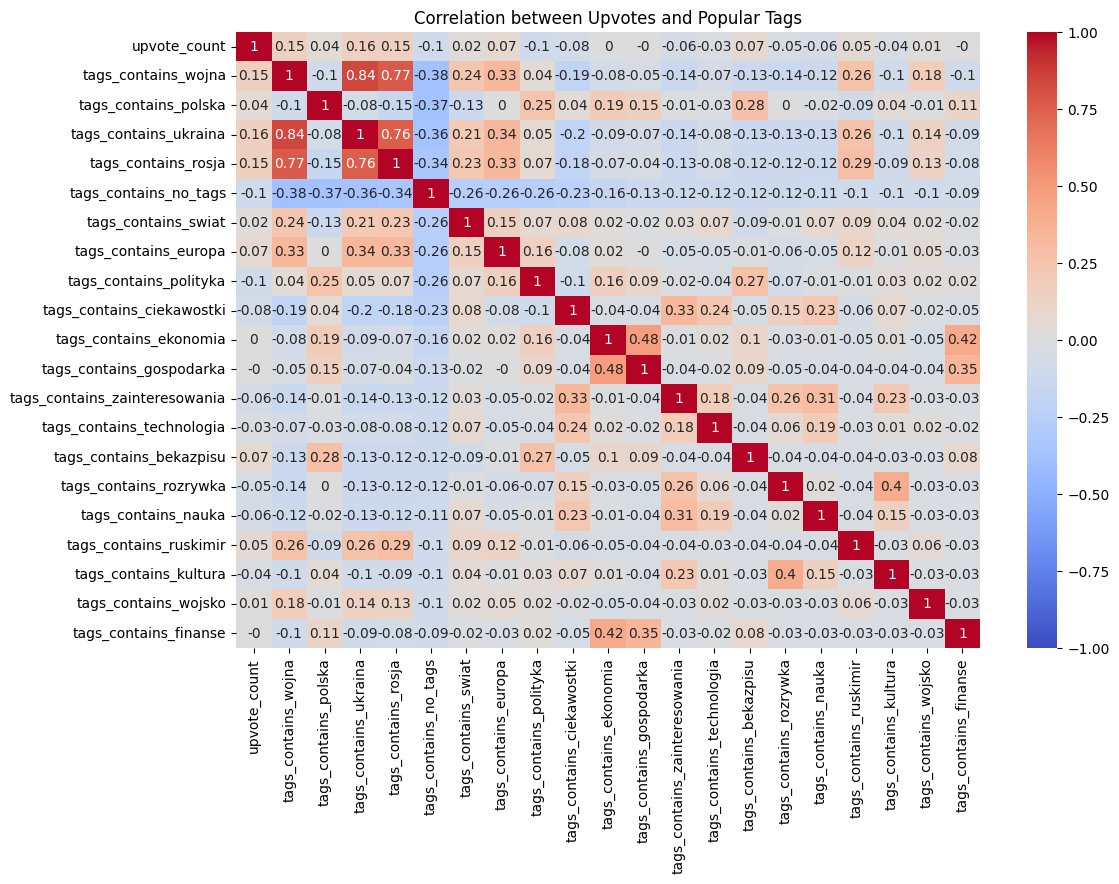

In [142]:
# Calculate the correlation between the new tag features and upvote_count
correlation_matrix = df[['upvote_count'] + [f'tags_contains_{tag}' for tag in top_tags]]
correlations = correlation_matrix.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations.round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Upvotes and Popular Tags')
plt.show()

### Setting up the validation framework

In [143]:
from sklearn.model_selection import train_test_split

In [146]:
def load_data(tfidf_top = 10, tags_top = 10, bottom_upvote = 0, top_upvote = 1000, most_common_words = 10):
    df = pd.read_csv(data_path + "processed_links.csv")
    df = df.reset_index(drop=True)

    # Filter DataFrame
    df = df[(df['upvote_count'] >= bottom_upvote) & (df['upvote_count'] <= top_upvote)]

    df['creation_date'] = pd.to_datetime(df['creation_date'])

    del df["Unnamed: 0"]
    del df["downvotes"]
    del df["upvotes"]
    del df["info"]
    del df["link_id"]
    del df["author_user_id"]
    del df["status"]
    del df["can_vote"]
    del df["archived"]
    
    df['hour_of_day'] = df['creation_date'].dt.hour
    df['description'] = df['description'].fillna("")
    df['tags'] = df['tags'].fillna("['no_tags']")
    # Apply cleaning and safely evaluate as list
    df['tags_cleaned'] = df['tags'].apply(clean_tags)
    df['tags_list'] = df['tags_cleaned'].apply(ast.literal_eval)

    # Sort and join the tags
    df['tags_sorted_joined'] = df['tags_list'].apply(lambda x: '_'.join(sorted(x)))

    # Extract the day of the week
    df['day_of_week'] = df['creation_date'].dt.day_name()
    # Extract the hour and classify the time of day
    df['time_of_day'] = df['creation_date'].dt.hour.apply(classify_time_of_day)

    df['title_char_length'] = df['title'].str.len()
    df['title_length_bins'] = pd.cut(df['title_char_length'], bins=range(0, 150, 30))
    df['description_char_length'] = df['description'].str.len()

    df['title_word_count'] = df['title'].str.split().apply(len)
    df['description_word_count'] = df['description'].str.split().apply(len)

    df['title_unique_word_count'] = df['title'].str.split().apply(lambda x: len(set(x)))
    df['description_unique_word_count'] = df['description'].str.split().apply(lambda x: len(set(x)))

    df['title_sentiment_polarity'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['title_sentiment_subjectivity'] = df['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    df['description_sentiment_polarity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['description_sentiment_subjectivity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    df['title_sentiment_group'] = df['title_sentiment_polarity'].apply(categorize_sentiment)
    df['description_sentiment_group'] = df['description_sentiment_polarity'].apply(categorize_sentiment)

    df['title_tokens'] = df['title'].apply(lambda x: tokenize_and_clean(x) if isinstance(x, str) else [])
    df['description_tokens'] = df['description'].apply(lambda x: tokenize_and_clean(x) if isinstance(x, str) else [])

    popular_threshold = 100
    popular_posts = df[df['upvote_count'] > popular_threshold]
    popular_posts.head().T
    
    popular_title_tokens = [token for tokens in popular_posts['title_tokens'] for token in tokens]
    # popular_description_tokens = [token for tokens in popular_posts['description_tokens'] for token in tokens]

    popular_title_word_freq = Counter(popular_title_tokens)
    # popular_description_word_freq = Counter(popular_description_tokens)

    # Most common words
    popular_title_top_words = popular_title_word_freq.most_common(most_common_words)

    # Example words to investigate
    words_to_check = [word for word, count in popular_title_top_words]
    words_to_check

    title_contains_features = []

    for word in words_to_check:
        title_name = f'title_contains_{word}'
        df[title_name] = df['title'].str.contains(word, case=False, na=False).astype(int)
        title_contains_features.append(title_name)
    
    df['title_avg_word_length'] = df['title'].apply(lambda x: np.mean([len(word) for word in x.split()]) if pd.notnull(x) else 0)
    df['description_avg_word_length'] = df['description'].apply(lambda x: np.mean([len(word) for word in x.split()]) if pd.notnull(x) else 0)
    df['description_avg_word_length'] = df['description_avg_word_length'].fillna(0.0)

    tfidf = TfidfVectorizer(max_features=tfidf_top)  # Adjust max_features as needed
    tfidf_matrix = tfidf.fit_transform(df['title'].fillna(''))

    # Convert to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    tfidf_df.head().T

    correlations = tfidf_df.corrwith(df['upvote_count'])

    # Sort by absolute correlation
    correlations = correlations.abs().sort_values(ascending=False)
    tfidf_top_features = correlations.head(tfidf_top).index
    tfidf_top_df = tfidf_df[tfidf_top_features]
    tfidf_top_df

    # Concatenate the filtered TF-IDF DataFrame with the original DataFrame
    df = pd.concat([df.reset_index(drop=True), tfidf_top_df.reset_index(drop=True)], axis=1)

    all_tags = df['tags_list'].explode()        

    # Count the occurrences of each tag
    tag_counts = all_tags.value_counts()
    tag_counts
    top_tags = tag_counts.head(tags_top).index
    tag_features = []
    for tag in top_tags:
        tag_feature_name = f'tags_contains_{tag}'
        df[tag_feature_name] = df['tags_sorted_joined'].str.contains(tag, case=False, na=False).astype(int)
        tag_features.append(tag_feature_name)

    return df, title_contains_features, tfidf_top_features, tag_features

In [147]:
def split_data(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, shuffle=True)

    y_train = np.log1p(df_train.upvote_count.values)
    y_val = np.log1p(df_val.upvote_count.values)
    y_test = np.log1p(df_test.upvote_count.values)

    del df_train["upvote_count"]
    del df_val["upvote_count"]
    del df_test["upvote_count"]

    return df_full_train, df_train, y_train, df_val, y_val, df_test, y_test

In [148]:
df_10, title_contains_features_10, tfidf_top_features_10, tag_features_10 = load_data(tfidf_top=10, tags_top=10, bottom_upvote=0, top_upvote=3000, most_common_words=10)
df_30, title_contains_features_30, tfidf_top_features_30, tag_features_30 = load_data(tfidf_top=30, tags_top=30, bottom_upvote=0, top_upvote=3000, most_common_words=30)
df_100, title_contains_features_100, tfidf_top_features_100, tag_features_100 = load_data(tfidf_top=100, tags_top=100, bottom_upvote=0, top_upvote=3000, most_common_words=100)

/var/folders/kn/5gkcnk6s4f1034nhqxdv53z80000gn/T/ipykernel_53414/3067297781.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + "processed_links.csv")
/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/kn/5gkcnk6s4f1034nhqxdv53z80000gn/T/ipykernel_53414/3067297781.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + "processed_links.csv")
/Users/piotrstanczak/Libra

In [149]:
def get_features(use_categorical = 10):
    numerical = [
        'comments_count',
        'related_count',
        'hour_of_day',
        'title_char_length',
        'description_char_length',
        'title_word_count',
        'description_word_count',
        'title_unique_word_count',
        'description_unique_word_count',
        'title_avg_word_length',
        'description_avg_word_length',
        'title_sentiment_polarity',
        'title_sentiment_subjectivity', 
        'description_sentiment_polarity',
        'description_sentiment_subjectivity', 
    ]

    base_categorical = [
        'plus18',        
        'day_of_week',
        'time_of_day',   
    ]

    df = None

    if use_categorical == 10:
        categorical = base_categorical + title_contains_features_10 + list(tfidf_top_features_10) + tag_features_10
        df = df_10
    elif use_categorical == 30:
        categorical = base_categorical + title_contains_features_30 + list(tfidf_top_features_30) + tag_features_30
        df = df_30
    elif use_categorical == 100:
        categorical = base_categorical + title_contains_features_100 + list(tfidf_top_features_100) + tag_features_100
        df = df_100
    return df, categorical, numerical

## Training the model

### LinearRegression

In [150]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split


In [151]:
def train_lr(df, y_train, features):
    dicts = df[features].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LinearRegression()
    model.fit(X_train, y_train)
    return dv, model

def predict_lr(df, dv, model, features):
    val_dicts = df[features].to_dict(orient="records")
    X_val = dv.transform(val_dicts)
    y_pred = model.predict(X_val)
    return y_pred

def validate_lr_model(df, features, title):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)
    dv, model = train_lr(df_train, y_train, features)
    y_pred = predict_lr(df_val, dv, model, features)
    rmse = root_mean_squared_error(y_val, y_pred)
    sns.histplot(y_pred, color='red', bins=50, alpha=0.5) 
    sns.histplot(y_val, color='blue', alpha=0.5, bins=50)
    plt.title(title)
    plt.show()
    return rmse

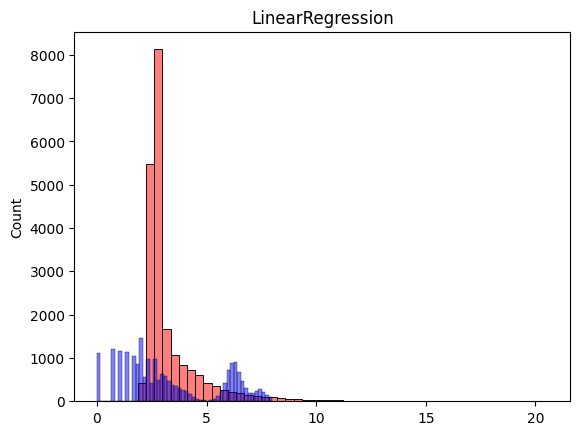

1.6526795946342532

In [152]:
baseline_features = [
    'comments_count',
    'title_char_length', 
    'description_char_length', 
    'hour_of_day'
]
validate_lr_model(df_100, baseline_features, "LinearRegression")

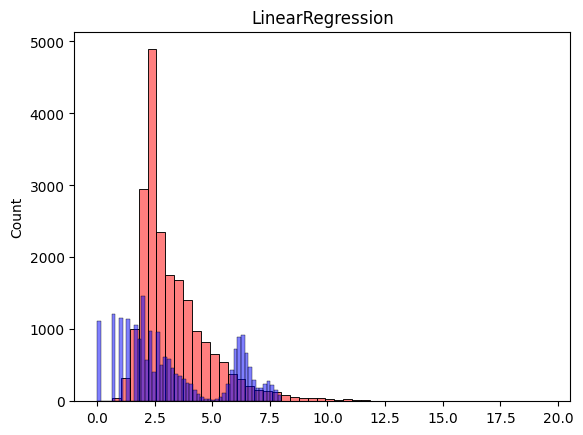

1.5014682959853578

In [153]:
df, categorical, numerical  = get_features(use_categorical=30) 
validate_lr_model(df, categorical + numerical, "LinearRegression")

### RidgeRegression

In [154]:
from sklearn.linear_model import Ridge

In [155]:
def train_rr(df, y_train, features, r=1):
    dicts = df[features].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = Ridge(alpha=r)
    model.fit(X_train, y_train)
    return dv, model

def predict_rr(df, dv, model, features):
    val_dicts = df[features].to_dict(orient="records")
    X_val = dv.transform(val_dicts)
    y_pred = model.predict(X_val)
    return y_pred

def validate_rr_model(df, features, title):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)
    dv, model = train_rr(df_train, y_train, features)
    y_pred = predict_rr(df_val, dv, model, features)
    rmse = root_mean_squared_error(y_val, y_pred)
    sns.histplot(y_pred, color='red', bins=50, alpha=0.5) 
    sns.histplot(y_val, color='blue', alpha=0.5, bins=50)
    plt.title(title)
    plt.show()
    return rmse

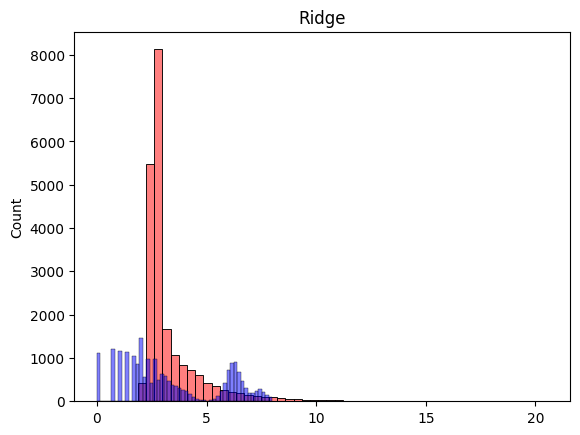

1.6526795949149289

In [156]:
small_baseline_features = [
    'comments_count',
    'title_char_length', 
    'description_char_length', 
    'hour_of_day'
]
validate_rr_model(df_10, small_baseline_features, "Ridge")

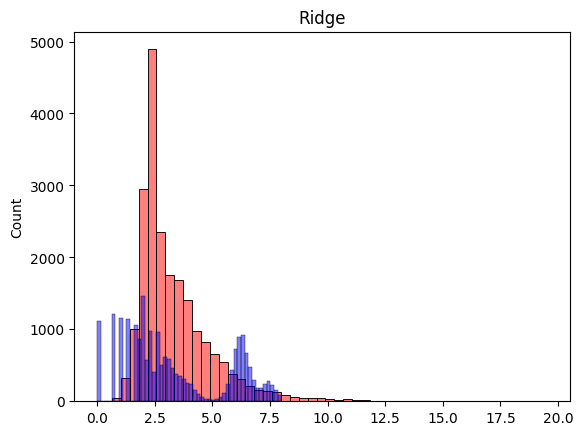

1.5012863185447993

In [157]:
df, categorical, numerical  = get_features(use_categorical=30) 
validate_rr_model(df, categorical + numerical , "Ridge")

In [158]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
baseline_features = categorical + numerical
for r in r_values:    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)    
    
    dv, model = train_rr(df_train, y_train, baseline_features, r=r)
    y_pred = predict_rr(df_val, dv, model, baseline_features)
    rmse = root_mean_squared_error(y_val, y_pred)
    print(f"R: {r} - {rmse}")

R: 0 - 1.5014325091543659
R: 0.01 - 1.501464200325174
R: 0.1 - 1.5014314924149843
R: 1 - 1.5012863185447993
R: 5 - 1.5011789306987853
R: 10 - 1.5011514040313234
R: 100 - 1.5015228216144323


### Lasso

In [159]:
from sklearn.linear_model import Lasso

In [160]:
def train_lasso(df, y_train, features, r=1):
    dicts = df[features].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = Lasso(alpha=r)
    model.fit(X_train, y_train)
    return dv, model

def predict_lasso(df, dv, model, features):
    val_dicts = df[features].to_dict(orient="records")
    X_val = dv.transform(val_dicts)
    y_pred = model.predict(X_val)
    return y_pred

def validate_lasso_model(df, features, title):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)
    dv, model = train_lasso(df_train, y_train, features)
    y_pred = predict_lasso(df_val, dv, model, features)
    rmse = root_mean_squared_error(y_val, y_pred)
    sns.histplot(y_pred, color='red', bins=50, alpha=0.5) 
    sns.histplot(y_val, color='blue', alpha=0.5, bins=50)
    plt.title(title)
    plt.show()
    return rmse

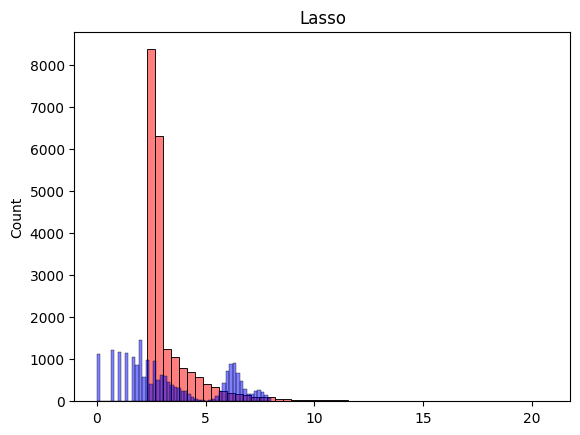

1.6576493752338863

In [161]:
validate_lasso_model(df, small_baseline_features, "Lasso")

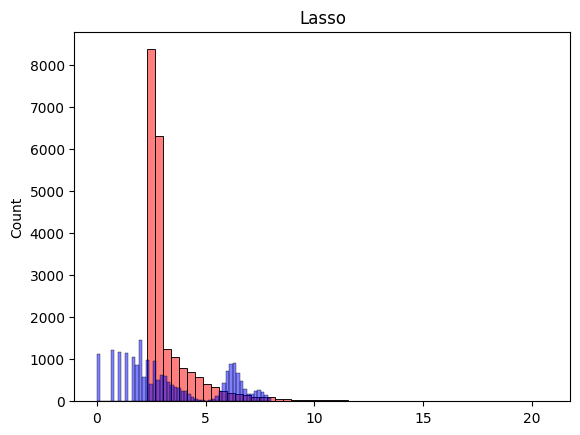

1.6576493752338863

In [162]:
df, categorical, numerical  = get_features(use_categorical=30) 
validate_lasso_model(df, categorical + numerical, "Lasso")

In [163]:
r_values = [0.01, 0.1, 1, 5, 10, 100]

for r in r_values:    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)    
    
    dv, model = train_lasso(df_train, y_train, small_baseline_features, r=r)
    y_pred = predict_lasso(df_val, dv, model, small_baseline_features)
    rmse = root_mean_squared_error(y_val, y_pred)
    print(f"R: {r} - {rmse}")

R: 0.01 - 1.6526902958170495
R: 0.1 - 1.6528970406178751
R: 1 - 1.6576493752338863
R: 5 - 1.6647912340629385
R: 10 - 1.670430001586416
R: 100 - 2.230876191253175


In [164]:
r_values = [0.01, 0.1, 1, 5, 10, 100]

for r in r_values:    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)    
    
    dv, model = train_lasso(df_train, y_train, categorical + numerical, r=r)
    y_pred = predict_lasso(df_val, dv, model, categorical + numerical)
    rmse = root_mean_squared_error(y_val, y_pred)
    print(f"R: {r} - {rmse}")

R: 0.01 - 1.523768499231204
R: 0.1 - 1.575517281742134
R: 1 - 1.6576493752338863
R: 5 - 1.6647912340629385
R: 10 - 1.670430001586416
R: 100 - 2.230876191253175


## Feature scaling + OHE

Scale the Data: Logistic regression can benefit significantly from feature scaling, especially if the features are on different scales. You can use StandardScaler or MinMaxScaler from scikit-learn to scale your features.


In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [166]:
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)    

In [167]:
numerical

['comments_count',
 'related_count',
 'hour_of_day',
 'title_char_length',
 'description_char_length',
 'title_word_count',
 'description_word_count',
 'title_unique_word_count',
 'description_unique_word_count',
 'title_avg_word_length',
 'description_avg_word_length',
 'title_sentiment_polarity',
 'title_sentiment_subjectivity',
 'description_sentiment_polarity',
 'description_sentiment_subjectivity']

In [168]:
small_categorical = [
    'plus18',    
    'day_of_week',
    'time_of_day',    
]

In [169]:
def test_ss_ohe(df_train, y_train, numerical, categorical):
    X_train_num = df_train[numerical].values
    X_train_num

    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df_train[categorical].values)
    X_train = np.column_stack([X_train_num, X_train_cat])
    model = LinearRegression()
    model.fit(X_train, y_train)
    X_val_num = df_val[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df_val[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [170]:
test_ss_ohe(df_train, y_train, numerical, small_categorical)

1.6278296983581702

In [171]:
# This might take some time
# test_ss_ohe(df_train, y_train, numerical, categorical)

In [172]:
def train_ss(df, y_train, categorical, numerical, model = "LinearRegression", r = 0.01):
    X_train_num = df[numerical].values

    scaler = StandardScaler()

    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])
    if model == "LinearRegression":
        model = LinearRegression()
    elif model == "Ridge":
        model = Ridge(alpha=r)
    elif model == "Lasso":
        model = Lasso(alpha=r)
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_ss(df, scaler, ohe, model, y_val, categorical, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

### LinearRegression with StandardScaler 

In [173]:
df, categorical, numerical  = get_features(use_categorical=10) 
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)    
    
scaler, ohe, model = train_ss(df_train, y_train, categorical, numerical, model="LinearRegression")
rmse = predict_ss(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

1.5410753702785216

### Ridge with StandardScaler

In [ ]:
df, categorical, numerical  = get_features(use_categorical=10) 
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
for r in r_values:    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                
    scaler, ohe, model = train_ss(df_train, y_train, categorical, numerical, model="Ridge", r=r)
    rmse = predict_ss(df_val, scaler, ohe, model, y_val, categorical, numerical)
    print(f"R: {r} - {rmse}")

R: 0 - 1075110767205.7379
R: 0.01 - 1.5410537502885258
R: 0.1 - 1.5408671327686034
R: 1 - 1.539532659735898
R: 5 - 1.5372564557114707
R: 10 - 1.5362218316121492
R: 100 - 1.5338340592334807


## DecisionTreeRegressor with one hot encoding

In [179]:
from sklearn.tree import DecisionTreeRegressor

In [182]:
def train_dtr_with_ohe(df, y_train, features, max_depth, min_samples_split = 2, min_samples_leaf = 1):
    dicts = df[features].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = DecisionTreeRegressor(
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    return dv, model

def predict_dtr_with_ohe(df, dv, model, y_val, features):
    val_dicts = df[features].to_dict(orient="records")
    X_val = dv.transform(val_dicts)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [183]:
df, categorical, numerical  = get_features(use_categorical=10) 

for max_depth in range(1, 30, 2):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df) 
        
    dv, model = train_dtr_with_ohe(df_train, y_train, categorical + numerical, max_depth=max_depth)
    rmse = predict_dtr_with_ohe(df_val, dv, model, y_val, categorical + numerical)
    print(f"Max depth: {max_depth} - rmse: {rmse}")

Max depth: 1 - rmse: 1.1484582980530458
Max depth: 3 - rmse: 0.9962758131545274
Max depth: 5 - rmse: 0.9563139193140839
Max depth: 7 - rmse: 0.9516615794892361
Max depth: 9 - rmse: 0.9593622418884782
Max depth: 11 - rmse: 0.9899805448620717
Max depth: 13 - rmse: 1.018281886606642
Max depth: 15 - rmse: 1.0543882746616133
Max depth: 17 - rmse: 1.099941638810563
Max depth: 19 - rmse: 1.138300286208872
Max depth: 21 - rmse: 1.1767344514108622
Max depth: 23 - rmse: 1.2039745836153128
Max depth: 25 - rmse: 1.2342677750140008
Max depth: 27 - rmse: 1.2521796677032158
Max depth: 29 - rmse: 1.2684750998710135


In [185]:
max_depth = 5
scores = []
for min_samples_split in range(2, 20, 1):
    for min_samples_leaf in range(1, 20, 1):        
        df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)             
        dv, model = train_dtr_with_ohe(df_train, y_train, categorical + numerical, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        rmse = predict_dtr_with_ohe(df_val, dv, model, y_val, categorical + numerical)
        scores.append((min_samples_split, min_samples_leaf, rmse))
scores

[(2, 1, 0.9563139193140839),
 (2, 2, 0.9563139193140839),
 (2, 3, 0.9563139193140839),
 (2, 4, 0.9563139193140839),
 (2, 5, 0.9563139193140839),
 (2, 6, 0.9563139193140839),
 (2, 7, 0.9563139193140839),
 (2, 8, 0.9563139193140839),
 (2, 9, 0.9563139193140839),
 (2, 10, 0.9563139193140839),
 (2, 11, 0.9563139193140839),
 (2, 12, 0.9563139193140839),
 (2, 13, 0.9563139193140839),
 (2, 14, 0.9563139193140839),
 (2, 15, 0.9563139193140839),
 (2, 16, 0.9563139193140839),
 (2, 17, 0.9563139193140839),
 (2, 18, 0.9563139193140839),
 (2, 19, 0.9563139193140839),
 (3, 1, 0.9563139193140839),
 (3, 2, 0.9563139193140839),
 (3, 3, 0.9563139193140839),
 (3, 4, 0.9563139193140839),
 (3, 5, 0.9563139193140839),
 (3, 6, 0.9563139193140839),
 (3, 7, 0.9563139193140839),
 (3, 8, 0.9563139193140839),
 (3, 9, 0.9563139193140839),
 (3, 10, 0.9563139193140839),
 (3, 11, 0.9563139193140839),
 (3, 12, 0.9563139193140839),
 (3, 13, 0.9563139193140839),
 (3, 14, 0.9563139193140839),
 (3, 15, 0.9563139193140839)

In [186]:
df_scores = pd.DataFrame(scores, columns=["min_samples_split", "min_samples_leaf", "rmse"])
df_scores.head()
df_score_pivot = df_scores.pivot(index="min_samples_split", columns=["min_samples_leaf"], values=["rmse"])
df_score_pivot.round(3)
df_score_pivot

rmse                                                    \
min_samples_leaf         1         2         3         4         5         6    
min_samples_split                                                               
2                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
3                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
4                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
5                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
6                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
7                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
8                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
9                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
10                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
11                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
12                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
13                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
14                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
15                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
16                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
17                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
18                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
19                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   

                                                                               \
min_samples_leaf         7         8         9         10        11        12   
min_samples_split                                                               
2                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
3                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
4                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
5                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
6                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
7                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
8                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
9                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
10                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
11                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
12                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
13                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
14                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
15                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
16                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
17                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
18                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
19                 0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   

                                                                               \
min_samples_leaf         13        14        15        16        17        18   
min_samples_split                                                               
2                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
3                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
4                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
5                  0.956314  0.956314  0.956314  0.956314  0.956314  0.956314   
6                  0.956314  0.956314  0.956314  0.9

In [188]:
max_depth = 5
min_samples_split = 2
min_samples_leaf = 1
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)             
dv, model = train_dtr_with_ohe(df_train, y_train, categorical + numerical, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
rmse = predict_dtr_with_ohe(df_val, dv, model, y_val, categorical + numerical)
rmse
# Best RMSE when using DecisionTreeRegressor with one hot encoding

0.9563139193140839

## DecisionTreeRegressor with StandardScaler

In [189]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [190]:
def train_dtr_with_scaler(df, y_train, categorical, numerical, max_depth, min_samples_split = 2, min_samples_leaf = 1):
    X_train_num = df[numerical].values

    scaler = StandardScaler()

    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])
    model = DecisionTreeRegressor(
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_dtr_with_scaler(df, scaler, ohe, model, y_val, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [191]:
numerical

['comments_count',
 'related_count',
 'hour_of_day',
 'title_char_length',
 'description_char_length',
 'title_word_count',
 'description_word_count',
 'title_unique_word_count',
 'description_unique_word_count',
 'title_avg_word_length',
 'description_avg_word_length',
 'title_sentiment_polarity',
 'title_sentiment_subjectivity',
 'description_sentiment_polarity',
 'description_sentiment_subjectivity']

In [192]:
categorical = [
    'plus18',
    'day_of_week',
    'time_of_day',    
]

In [ ]:
for max_depth in range(1, 30, 2):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df) 
        
    scaler, ohe, model = train_dtr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth)
    rmse = predict_dtr_with_scaler(df_val, scaler, ohe, model, y_val, numerical)
    print(f"Max depth: {max_depth} - {rmse}")

Max depth: 1 - 1.1484582980530458
Max depth: 3 - 1.0011853587628654
Max depth: 5 - 0.9839218494074536
Max depth: 7 - 0.9836941825573425
Max depth: 9 - 0.997894203096709
Max depth: 11 - 1.0269309352766116
Max depth: 13 - 1.0685374623568518
Max depth: 15 - 1.120297817451094
Max depth: 17 - 1.1782488252464984
Max depth: 19 - 1.2250239290577052
Max depth: 21 - 1.2681941992558547
Max depth: 23 - 1.3000400435374841
Max depth: 25 - 1.3285913357384327
Max depth: 27 - 1.345096484341463
Max depth: 29 - 1.3691276530896033


In [194]:
df, categorical, numerical  = get_features(use_categorical=10) 
for max_depth in range(1, 30, 2):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)         
    scaler, ohe, model = train_dtr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth)
    rmse = predict_dtr_with_scaler(df_val, scaler, ohe, model, y_val, numerical)
    print(f"Max depth: {max_depth} - {rmse}")

Max depth: 1 - 1.1484582980530458
Max depth: 3 - 0.9962758131545275
Max depth: 5 - 0.956313919314084
Max depth: 7 - 0.9508378509757416
Max depth: 9 - 0.9609703922858395
Max depth: 11 - 0.9849538424907014
Max depth: 13 - 1.0123617123522455
Max depth: 15 - 1.046369046886045
Max depth: 17 - 1.0808558992773716
Max depth: 19 - 1.126707365802388
Max depth: 21 - 1.1609876541344348
Max depth: 23 - 1.182859495734759
Max depth: 25 - 1.2082143078657452
Max depth: 27 - 1.233628564394794
Max depth: 29 - 1.2466616766947662


In [196]:
max_depth = 7
scores = []
for min_samples_split in range(2, 6, 1):
    for min_samples_leaf in range(2, 6, 1):        
        df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     
        scaler, ohe, model = train_dtr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        rmse = predict_dtr_with_scaler(df_val, scaler, ohe, model, y_val, numerical)
        scores.append((min_samples_split, min_samples_leaf, rmse))
scores

[(2, 2, 0.9517881350713262),
 (2, 3, 0.9512553788783586),
 (2, 4, 0.9500680194242753),
 (2, 5, 0.9499900987478657),
 (3, 2, 0.9517881350713262),
 (3, 3, 0.9512553788783586),
 (3, 4, 0.9500680194242753),
 (3, 5, 0.9499900987478657),
 (4, 2, 0.9517881350713262),
 (4, 3, 0.9512553788783586),
 (4, 4, 0.9500680194242753),
 (4, 5, 0.9499900987478657),
 (5, 2, 0.9517881350713262),
 (5, 3, 0.9512553788783586),
 (5, 4, 0.9500680194242753),
 (5, 5, 0.9499900987478657)]

In [197]:
df_scores = pd.DataFrame(scores, columns=["min_samples_split", "min_samples_leaf", "rmse"])
df_scores.head()
df_score_pivot = df_scores.pivot(index="min_samples_split", columns=["min_samples_leaf"], values=["rmse"])
df_score_pivot.round(3)
df_score_pivot

rmse                             
min_samples_leaf          2         3         4        5
min_samples_split                                       
2                  0.951788  0.951255  0.950068  0.94999
3                  0.951788  0.951255  0.950068  0.94999
4                  0.951788  0.951255  0.950068  0.94999
5                  0.951788  0.951255  0.950068  0.94999

In [198]:
max_depth = 7
min_samples_split = 2
min_samples_leaf = 5
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_dtr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
rmse = predict_dtr_with_scaler(df_val, scaler, ohe, model, y_val, numerical)
rmse  # Best RMSE when using DecisionTreeRegressor with StandarScaler
        

0.9499900987478657

## RandomForestRegressor

In [199]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [200]:
def train_rfr_with_scaler(
        df, 
        y_train, 
        categorical, 
        numerical,
        n_estimators=10,
        random_state=1,
        min_samples_leaf=1,
        max_features=1.0,
        bootstrap = True,
        max_depth=None,
        n_jobs=-1):
    X_train_num = df[numerical].values

    scaler = StandardScaler()

    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state,
        n_jobs=n_jobs,
        max_features=max_features,
        bootstrap=bootstrap
    )
    
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_rfr_with_scaler(df, scaler, ohe, model, y_val, categorical, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [201]:
df, categorical, numerical  = get_features(use_categorical=10) 
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_rfr_with_scaler(df_train, y_train, categorical, numerical)
rmse = predict_rfr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

0.9764264647943022

In [202]:
scores = []
for n in range(10, 201, 10):   
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

    scaler, ohe, model = train_rfr_with_scaler(df_train, y_train, categorical, numerical, n_estimators=n)
    rmse = predict_rfr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
    scores.append((n, rmse))
    print(f"N_estimators: {n} - {rmse}")
scores

N_estimators: 10 - 0.9764264647943022
N_estimators: 20 - 0.9518794348439195
N_estimators: 30 - 0.946018175582467
N_estimators: 40 - 0.9423274888429235
N_estimators: 50 - 0.9406227217698016
N_estimators: 60 - 0.9385812104417807
N_estimators: 70 - 0.9371833248711422
N_estimators: 80 - 0.9361978469070773
N_estimators: 90 - 0.9356866275926803
N_estimators: 100 - 0.9355405257870172
N_estimators: 110 - 0.9348745514684961
N_estimators: 120 - 0.934480556495919
N_estimators: 130 - 0.933980003399169
N_estimators: 140 - 0.9335172762237914
N_estimators: 150 - 0.9331621465467013
N_estimators: 160 - 0.9328838003250665
N_estimators: 170 - 0.932776265876855
N_estimators: 180 - 0.9324613380008473
N_estimators: 190 - 0.9322815841884838
N_estimators: 200 - 0.9320353098165522


[(10, 0.9764264647943022),
 (20, 0.9518794348439195),
 (30, 0.946018175582467),
 (40, 0.9423274888429235),
 (50, 0.9406227217698016),
 (60, 0.9385812104417807),
 (70, 0.9371833248711422),
 (80, 0.9361978469070773),
 (90, 0.9356866275926803),
 (100, 0.9355405257870172),
 (110, 0.9348745514684961),
 (120, 0.934480556495919),
 (130, 0.933980003399169),
 (140, 0.9335172762237914),
 (150, 0.9331621465467013),
 (160, 0.9328838003250665),
 (170, 0.932776265876855),
 (180, 0.9324613380008473),
 (190, 0.9322815841884838),
 (200, 0.9320353098165522)]

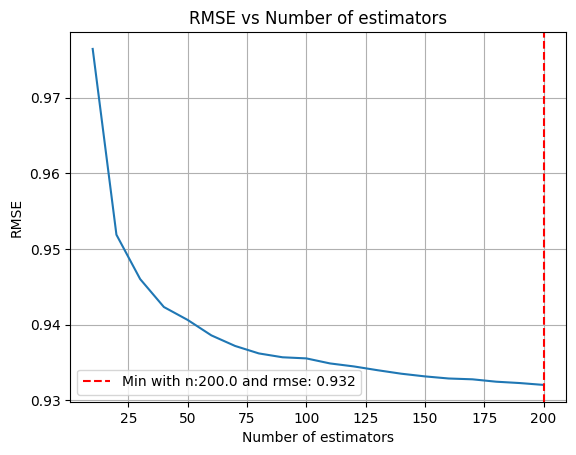

In [203]:
df_scores = pd.DataFrame(scores, columns=["n", "rmse"])

max_idx = df_scores.rmse.idxmin()
n_value = df_scores.iloc[max_idx].n
rmse_value = df_scores.iloc[max_idx].rmse

plt.plot(df_scores.n, df_scores.rmse)
plt.axvline(
    x=n_value,
    color="red",
    linestyle="--",
    label=f"Min with n:{n_value} and rmse: {rmse_value:.3f}",
)

plt.xlabel("Number of estimators")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of estimators")
plt.legend()
plt.grid(True)

In [205]:
n_estimators = 180
scores = []
for d in range(8, 12, 2):       
        df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

        scaler, ohe, model = train_rfr_with_scaler(df_train, y_train, categorical, numerical, n_estimators=n_estimators, max_depth=d)
        rmse = predict_rfr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)        
        scores.append((d, n_estimators, rmse))

        print(f"Depth: {d}  - {rmse}")
scores

Depth: 8  - 0.9313370327622333
Depth: 10  - 0.9270835690135095


[(8, 180, 0.9313370327622333), (10, 180, 0.9270835690135095)]

In [207]:
max_depth = 10
n_estimators = 180
scores = []
for s in [1, 3, 5, 10, 50]:    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     
    scaler, ohe, model = train_rfr_with_scaler(df_train, y_train, categorical, numerical, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=s)
    rmse = predict_rfr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)        
    scores.append((max_depth, n_estimators, s, rmse))
    print(f"min_samples_leaf: {s}  - {rmse}")
scores

min_samples_leaf: 1  - 0.9270835690135095
min_samples_leaf: 3  - 0.9262550951117894
min_samples_leaf: 5  - 0.9264530664176752
min_samples_leaf: 10  - 0.9273362061890865
min_samples_leaf: 50  - 0.931470203438452


[(10, 180, 1, 0.9270835690135095),
 (10, 180, 3, 0.9262550951117894),
 (10, 180, 5, 0.9264530664176752),
 (10, 180, 10, 0.9273362061890865),
 (10, 180, 50, 0.931470203438452)]

In [208]:
max_depth = 10
n_estimators = 180
min_samples_leaf = 3
scores = []
for f in range(1, 10, 1):    
    df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

    scaler, ohe, model = train_rfr_with_scaler(df_train, y_train, categorical, numerical, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=f)
    rmse = predict_rfr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)        
    scores.append((f, rmse))
    print(f"max_features: {f}  - {rmse}")
scores

max_features: 1  - 2.229236109298899
max_features: 2  - 2.227919181332085
max_features: 3  - 2.2159124195444786
max_features: 4  - 2.2134978688005793
max_features: 5  - 2.2025619353849435
max_features: 6  - 2.1664192576298813
max_features: 7  - 2.1594240067073227
max_features: 8  - 2.141894064425104
max_features: 9  - 2.1283973401628504


[(1, 2.229236109298899),
 (2, 2.227919181332085),
 (3, 2.2159124195444786),
 (4, 2.2134978688005793),
 (5, 2.2025619353849435),
 (6, 2.1664192576298813),
 (7, 2.1594240067073227),
 (8, 2.141894064425104),
 (9, 2.1283973401628504)]

#### XGBRegressor

In [209]:
from xgboost import XGBRegressor

In [212]:
def train_xgbr_with_scaler(
        df, 
        y_train, 
        categorical, 
        numerical,
        n_estimators=10,        
        max_depth=None,
        n_jobs=-1,
        learning_rate = 0.1):
    X_train_num = df[numerical].values

    scaler = StandardScaler()

    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])
    
    model = XGBRegressor(
        n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=n_jobs
    )    
    
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_xgbr_with_scaler(df, scaler, ohe, model, y_val, categorical, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [213]:
max_depth = 3
n_estimators = 100
learning_rate = 0.1

df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_xgbr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
rmse = predict_xgbr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

0.924699046753587

In [214]:
max_depth = 5
n_estimators = 190
learning_rate = 0.1

df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_xgbr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
rmse = predict_xgbr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

0.9160471330192149

#### Support Vector Machines

In [216]:
from sklearn.svm import SVR

In [217]:
def train_svr_with_scaler(
        df, 
        y_train, 
        categorical, 
        numerical,
        ):
    X_train_num = df[numerical].values

    scaler = StandardScaler()

    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])
    
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)    
    
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_svr_with_scaler(df, scaler, ohe, model, y_val, categorical, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [219]:
df, categorical, numerical = get_features(use_categorical=10)

In [ ]:
# This takes to much time
# df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

# scaler, ohe, model = train_svr_with_scaler(df_train, y_train, categorical, numerical)
# rmse = predict_svr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
# rmse

#### MLPRegressor

In [220]:
from sklearn.neural_network import MLPRegressor

In [225]:
def train_mlpr_with_scaler(
        df, 
        y_train, 
        categorical, 
        numerical,        
        n_jobs=-1,
        ):
    X_train_num = df[numerical].values

    scaler = StandardScaler()

    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])
    
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, learning_rate='adaptive')
    
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_mlpr_with_scaler(df, scaler, ohe, model, y_val, categorical, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [223]:
df, categorical, numerical = get_features(use_categorical=10)

In [226]:
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_mlpr_with_scaler(df_train, y_train, categorical, numerical)
rmse = predict_mlpr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

0.9858338619343573

#### LGBMRegressor

In [227]:
from lightgbm import LGBMRegressor

In [228]:
def train_lgbmr_with_scaler(
        df, 
        y_train, 
        categorical, 
        numerical,
        n_estimators = 100,        
        max_depth = -1,
        learning_rate = 0.1,
        colsample_bytree = 1.0,
        min_child_samples = 20,
        num_leaves = 31, 
        subsample = 1.0
        ):
    X_train_num = df[numerical].values
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_train_num

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_cat = ohe.fit_transform(df[categorical].values)
    X_train_cat

    X_train = np.column_stack([X_train_num, X_train_cat])    
    model = LGBMRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        min_child_samples=min_child_samples,
        num_leaves=num_leaves,
        subsample=subsample
    )        
    model.fit(X_train, y_train)
    return scaler, ohe, model

def predict_lgbmr_with_scaler(df, scaler, ohe, model, y_val, categorical, numerical):
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [229]:
df, categorical, numerical = get_features(use_categorical=100)

In [230]:
max_depth = -1
n_estimators = 180
learning_rate = 0.1

df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_lgbmr_with_scaler(df_train, y_train, categorical, numerical, max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
rmse = predict_lgbmr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3635
[LightGBM] [Info] Number of data points in the train set: 63679, number of used features: 909
[LightGBM] [Info] Start training from score 3.340577


/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.8930729605873636

## Fine tune

In [231]:
param_grid = {
    'n_estimators': [150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [-1, 3],
    'num_leaves': [15, 31],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 1.0]
}

In [237]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor

# Preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(verbose=-1))
])

In [246]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*The LGBMRegressor or classes from which it inherits use.*")
warnings.filterwarnings("ignore", message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")



In [247]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={'model__' + k: v for k, v in param_grid.items()},
    scoring='neg_root_mean_squared_error',  # Use RMSE as the evaluation metric
    cv=2,  # 2-fold cross-validation
    verbose=0,
    n_jobs=-1  # Use all available cores
)

# Perform the grid search
grid_search.fit(df_train, y_train)

/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/piotrstanczak/Library/Caches/pypoetry/virtualenvs/predictingpostengagement-45Lz2LlT-py3.11/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklea

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['comments_count',
                                                                          'related_count',
                                                                          'hour_of_day',
                                                                          'title_char_length',
                                                                          'description_char_length',
                                                                          'title_word_count',
                                                                          'description_word_count',
                                                                          'title_unique_word_count',
                                                                          'description_unique_word_count',
                                                                          'title_avg_word_length',
                                                                          'description_a...
                                                                          'title_contains_żołnierzy', ...])])),
                                       ('model', LGBMRegressor(verbose=-1))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [-1, 3],
                         'model__min_child_samples': [10, 20],
                         'model__n_estimators': [150, 200],
                         'model__num_leaves': [15, 31],
                         'model__subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error')

In [248]:
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (Negative):", grid_search.best_score_)

# Best Parameters: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 200, 'model__num_leaves': 31, 'model__subsample': 0.8}
# Best RMSE (Negative): -0.8990932982068169

Best Parameters: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 200, 'model__num_leaves': 31, 'model__subsample': 0.8}
Best RMSE (Negative): -0.892768799489273


## Final model

In [249]:
df, categorical, numerical = get_features(use_categorical=100)

max_depth = -1
n_estimators = 180
learning_rate = 0.1
colsample_bytree = 0.6
min_child_samples = 20
num_leaves = 31
subsample = 1.0


In [250]:
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

scaler, ohe, model = train_lgbmr_with_scaler(df_train, y_train, categorical, numerical, 
                                             max_depth=max_depth, 
                                             n_estimators=n_estimators, 
                                             learning_rate=learning_rate, 
                                             colsample_bytree=colsample_bytree,
                                             min_child_samples=min_child_samples,
                                             num_leaves=num_leaves, 
                                             subsample=subsample                                        
                                             )
rmse = predict_lgbmr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

0.8932504337016844

## Full Train vs Test

In [251]:
df_full_train, df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)                     

full_df_train = pd.concat([df_train, df_val], axis=0, ignore_index=True)
full_df_train = full_df_train.reset_index(drop=True)
full_y_train = np.concatenate((y_train, y_val), axis=0)       

scaler, ohe, model = train_lgbmr_with_scaler(df_train, y_train, categorical, numerical, 
                                             max_depth=max_depth, 
                                             n_estimators=n_estimators, 
                                             learning_rate=learning_rate, 
                                             colsample_bytree=colsample_bytree,
                                             min_child_samples=min_child_samples,
                                             num_leaves=num_leaves, 
                                             subsample=subsample                                        
                                             )
rmse = predict_lgbmr_with_scaler(df_val, scaler, ohe, model, y_val, categorical, numerical)
rmse

0.8932504337016844

## Testing the model

In [253]:
def predict_post_upvote_count(df, scaler, ohe, model, categorical, numerical):    
    X_val_num = df[numerical].values
    X_val_num = scaler.transform(X_val_num)
    X_val_cat = ohe.transform(df[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    y_pred = model.predict(X_val)
    return y_pred

In [258]:
test_features = categorical + numerical
random = 100
post = df_test[test_features].iloc[random].to_dict()
post
upvote_count = y_test[random]
original_upvote = np.expm1(upvote_count)
df_single = pd.DataFrame([post])
df_single

y_pred = predict_post_upvote_count(df_single, scaler, ohe, model, categorical, numerical)
predicted_upvote = np.expm1(y_pred[0])
# Original upvote vs predicted
original_upvote.round(2), predicted_upvote.round(2)

(np.float64(262.0), np.float64(300.46))